In [75]:
### # Initial Code source by:                Gaël Varoquaux
#                                        Andreas Müller
# Modified for documentation by:         Jaques Grobler
# Mainly Modified for private usage by:  Ioannis Agriomallos
# License: BSD 3 clause
####################################################################################################################
######==================== CURRENT CODE USAGE ======================================================================
# -> Current code trains several ML Classifiers, to classify force input samples as stable (0) or slip (1)
######---- Input
# -> Input samples originate from optoforce sensors and are 3D (fx,fy,fz) and come from 3 different datasets, 
# containing several surfaces as well as slip-stable occurrences
######---- Input transformation
# -> Several pre-features are taken from these inputs.
# -> Several time and frequency domain features are extracted from pre-feature windows. 
# (implemented in 'newfeatext.py') These windows have size w and are shifted by s on each sample
# -> Then a feature selection-ranking is performed using MutualVariableInformation
# -> Finally PCA is performed to keep the desired among the best selected features
######---- Training of ML Classifiers
# -> Several ML Classifiers are trained for all combinations of features-datasets
######---- Stats report
# -> Several stats are reported on the classification results of the trained models, 
# based on their accuracy (fscore and auc as well) on test data as well as previously unseen data
######===================== POTENTIAL CODE EXTENSION FOR FURTHER MORE GENERIC USAGE ================================
# -> As binary classification problem it may apply to all such problems given that:
######----- Input
# -> Input is loaded on datasets, which expect (n,1) input with (k,4) dimensions each,
# where n data samples, k measurement in each sample, 3 force readings and 1 label for each measurement.
######----- Input transformation
# -> Pre-features must be changed or ommitted to fit your needs. 
# Here they served to transform the 3 (fx,fy,fz) force readings into one between (ft,fn,ft/fn,sf)
# -> Features are performed on the desired pre-features. They take a (n,o,m) input matrix and return a (n,o,l),
# where n data samples, o windows, m prefeatures, l features.
# -> Feature selection gives a ranking on each l, so we keep b from the best
# -> PCA is performed on the b selected features resulting in p dimensions (n,o,p) => (n*o,p)
######----- Training of ML Classifiers
# -> Each Classifier is trained on a subset of (n*o,p)
######----- Stats
# -> Change accordingly!
####################################################################################################################
print(__doc__)
import time
start_time = time.time()
from copy import deepcopy, copy
import math
import scipy.io as sio
import shutil
import os
from random import shuffle
import numpy as np
from pylab import *
from featext2 import *
import matplotlib.pyplot as plt
%matplotlib inline 
#matplotlib qt
# inline (suitable for ipython only, shown inside browser!) or qt (suitable in general, shown in external window!)
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D #, axes3d
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, ParameterGrid, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RandomizedLasso
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, mutual_info_classif, SelectFdr
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from collections import OrderedDict
import re
import datetime
import urllib
import tarfile
import joblib
from joblib import Parallel, delayed, Memory
from tempfile import mkdtemp
import copy_reg
import types
import itertools
#import multiprocessing
def _pickle_method(m):
    if m.im_self is None:
        return getattr, (m.im_class, m.im_func.func_name)
    else:
        return getattr, (m.im_self, m.im_func.func_name)
copy_reg.pickle(types.MethodType, _pickle_method)

h = .2  # step size in the mesh

# datapath = 'tmp/'
# featpath = datapath+'features/'

# names = ["NearNb", "LinSVM", "RBFSVM", "NaiveBayes", "LDA",
#          "QDA", "MLP", "Lasso", "Lin.Regr", "Log.Regr", "Dec.Tree",
#          "RandFor", "AdaBoost", "EnsembleMLP"]
# names = ["NearNb", "RBFSVM1", "RBFSVM2", "NaiveBayes", "LDA",
#          "QDA", "MLP1", "MLP2", "Lasso", "Lin.Regr", "Log.Regr", "Dec.Tree",
#          "RandFor", "AdaBoost", "EnsembleMLP"]
# names = ["NearNb", "LINSVM1", "RBFSVM1", "NaiveBayes", "LDA",
#          "QDA", "MLP1", "Lasso", "Lin.Regr", "Log.Regr", "Dec.Tree",
#          "RandFor", "AdaBoost", "EnsembleMLP"]
# names = ["NearNb", "RBFSVM1", "NaiveBayes", "MLP1", "Log.Regr", "RandFor", "AdaBoost", "EnsembleMLP"]
names = ["NearNb", "RBFSVM1", "MLP1", "RandFor", "EnsembleMLP"]
classifiers = [
    KNeighborsClassifier(5),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
    SVC(gamma='auto', C=1),
#     SVC(gamma='auto', C=100),
#     GaussianNB(),
#     LinearDiscriminantAnalysis(),
#     QuadraticDiscriminantAnalysis(),
    MLPClassifier(solver='lbfgs',alpha=1e-4,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
#     MLPClassifier(solver='lbfgs',alpha=1e-1,hidden_layer_sizes=(10,10),random_state=1,verbose=True),
#     MLPClassifier(solver='adam',epsilon=1e-5,alpha=1e-4,hidden_layer_sizes=(50,50),random_state=1,verbose=False),
#     MLPClassifier(solver='adam',epsilon=1e-5,alpha=1e-1,hidden_layer_sizes=(50,50),random_state=1,verbose=False),
#     LassoCV(),
#     LinearRegression(),
#     LogisticRegression(),
#     DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     AdaBoostClassifier(),
#     MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(len(names)-1,2),random_state=1,max_iter=500)
    MLPClassifier(solver='lbfgs',alpha=1e-5,hidden_layer_sizes=(len(names)-1,len(names)-1),random_state=1,max_iter=500)
    #VotingClassifier()
]

# classifiers = [SVC(),KNeighborsClassifier()]
cv = StratifiedKFold(n_splits=5, random_state=42)
# params = []


parameters_clf = [{'n_neighbors':[4,7,9,12]},
#               {},
              {'kernel':['rbf'], 'C':[0.1,10,100,1000]},
#               {},
#               {},
#               {},
              {'solver':['lbfgs'], 'alpha':[1e-5,1e-2], 'hidden_layer_sizes':[(10,10),(50,50)]},
#               {},
#               {},
#               {},
#               {'max_depth':[4,5,6,8,10]},
              {'max_depth':[4,7,10,20],'n_estimators':[5,10,20],'max_features':[20,35,50]}
#               {},
#               {'solver':['lbfgs'], 'alpha':[1e-5], 'hidden_layer_sizes':[(len(names)-1,len(names)-1),(len(names)-1,2)]}
             ]
makepipe_parameters_clf = [{'classifier__'+key:p[key] for key in p} for p in parameters_clf]
makepipe_parameters_clf += [{'feature_selection__k': (750,500,100), 'feature_selection__score_func': [mutual_info_classif]},
                            {'decomp__n_components': (100,50)}]

# print makepipe_parameters_clf


metric = ['accuracy','f1']
dataset = 0 # all datasets (0), dataset 1-2 (1), dataset 3 (2), dataset4 (3)
download = 1 # Download pre-computed (1) data or compute them anew (0)

Automatically created module for IPython interactive environment


In [64]:
######################################## INITIALISATION PARAMETERS #################################################
window, shift, keepfromshift = 256, 1, 10
samplesperdataset = 10000
havelabel = 1
returntime = 0
featlabel = 0         # 0: all features, 1: temporal, 2: frequency, 3: FFT only
magnFFT = 0           # 0: FFT in magnitude format, 1: FFT in real and imag format, 
featall = 0           # 0: all, 1: feat1 (phinyomark's), 2: feat2 (golz's)
featparam = [havelabel,featlabel,magnFFT,featall,returntime]
metr = metric[0]      # 0: accuracy, 1: f1score
CV = 5                # cross validation checks
prefeatid = [0,3,4]   # only the prefeatures with corresponding ids will be computed
datapath = 'tmp/'
featpath = datapath+'features/'+str(window)+'_'+str(shift)+'/'
numfeat = 10 # number of features to show
nfeat = 750 # number of features to keep

In [3]:
########################################## Download necessary files ################################################
# if download==1:
#     downpath = featpath
#     downfile = downpath+"features.tar.gz"
#     downlink = "https://www.dropbox.com/s/lx3ggezzq2wl2km/features.tar.gz?dl=1"
#     if not os.path.isfile(downfile):
#         u = urllib.urlopen(downlink)
#         data = u.read()
#         print 'Completed downloading ',len(data)*1./(1024**3),'GB of ',downfile,'!'
#         u.close()
#         with open(downfile, "wb") as f :
#             f.write(data)
#     else:
#         print 'Necessary ',downfile,'  already here!'
#     print 'Extracting files...'
#     directory = featpath
#     def extract_nonexisting(archive):
#         for name in archive.getnames():
#             if os.path.exists(os.path.join(directory, name)):
#                 print name, "already exists"
#             else:
#                 archive.extract(name, path=directory)
#     archives = [name for name in os.listdir(directory) if name.endswith("tar.gz")]
#     for archive_name in archives:
#         with tarfile.open(featpath+archive_name) as archive:
#             extract_nonexisting(archive)
# #     if (downfile.endswith("tar.gz")):
# #         tar = tarfile.open(downfile, "r:gz")
# #         tar.extractall(path=downpath)
# #         tar.close()
#     print 'Completed extracting files!'
########################################## Download necessary datasets #############################################
datafiles1 = datapath+'slipdataset12_trunc.mat'
if not os.path.isfile(datafiles1):
    downdata1 = "https://www.dropbox.com/s/w8y0rlg9kj6axxt/slipdataset12.mat?dl=1"
    u = urllib.urlopen(downdata1)
    data = u.read()
    print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafiles1,'!'
    u.close()
    with open(datafiles1, "wb") as f :
        f.write(data)
else:
    print 'Necessary ',datafiles1,' already here!'
datafiles2 = datapath+'slipdataset3_C.mat'
if not os.path.isfile(datafiles2):
    downdata2 = "https://www.dropbox.com/s/95znajbu6sga8iz/slipdataset3_C.mat?dl=1"
    u = urllib.urlopen(downdata2)
    data = u.read()
    print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafiles2,'!'
    u.close()
    with open(datafiles2, "wb") as f :
        f.write(data)
else:
    print 'Necessary ',datafiles2,' already here!'
datafiles3 = datapath+'allsurffinal.mat'
if not os.path.isfile(datafiles3):
#     downdata2 = "https://www.dropbox.com/s/95znajbu6sga8iz/slipdataset3_C.mat?dl=1"
#     u = urllib.urlopen(downdata2)
#     data = u.read()
#     print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',datafiles2,'!'
#     u.close()
#     with open(datafiles2, "wb") as f :
#         f.write(data)
    print 'Necessary ',datafiles3,' not here! DO SOMETHING ABOUT IT!'
else:
    print 'Necessary ',datafiles3,' already here!'
########################################## Download pretrained ML Classifiers models ###############################    
clfmodelfile = datapath+'trained_classifiers_trans_gs_subsample'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)+'.npz'
modelfile = datapath+'allmodels_trans_gs_subsample'+str(window)+'_'+str(shift)+'.npz'

featname = 'newfeatures_trans_subsample'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
featfile = featpath+featname+'.npz'
XYfile = featpath+featname+'_XY.npz'
XYnormfile = featpath+featname+'_XYnorm.npz'
# if not os.path.isfile(clfmodelfile):
#     downclf = "https://www.dropbox.com/s/po9m048ukqt1ahn/trained_classifiers.npz?dl=1"
#     u = urllib.urlopen(downclf)
#     data = u.read()
#     print 'Completed downloading ',len(data)*1./(1024**2),'MB of ',clfmodelfile,'!'
#     u.close()
#     with open(clfmodelfile, "wb") as f :
#         f.write(data)
# else:
#     print clfmodelfile,' already here!'

Necessary  tmp/slipdataset12_trunc.mat  already here!
Necessary  tmp/slipdataset3_C.mat  already here!
Necessary  tmp/allsurffinal.mat  already here!


1 (34, 1) (34, 1) (34, 1) (34,)
2 (7, 1) (7, 1) (7, 1) (7,)
3 (15, 1) (15, 1) (15, 1) (15, 1) (15,)
4 (56, 1) (56, 1) (56,)
5 (29, 1) (29, 1)
6 1.0 1.0 1.0
7 (29,) : [(1284, 4), (3909, 4), (2112, 4), (2039, 4), (3916, 4), (6136, 4), (6093, 4), (2467, 4), (40018, 4), (39994, 4), (40004, 4), (39852, 4), (39946, 4), (39896, 4), (24000, 4), (21000, 4), (20500, 4), (20500, 4), (23500, 4), (24000, 4), (24000, 4), (24000, 4), (24000, 4), (24000, 4), (24000, 4), (27000, 4), (27500, 4), (27500, 4), (27500, 4)]
8 (29,) : [(428, 4), (1303, 4), (704, 4), (680, 4), (1306, 4), (2046, 4), (2031, 4), (823, 4), (13340, 4), (13332, 4), (13335, 4), (13284, 4), (13316, 4), (13299, 4), (8000, 4), (7000, 4), (6834, 4), (6834, 4), (7834, 4), (8000, 4), (8000, 4), (8000, 4), (8000, 4), (8000, 4), (8000, 4), (9000, 4), (9167, 4), (9167, 4), (9167, 4)]


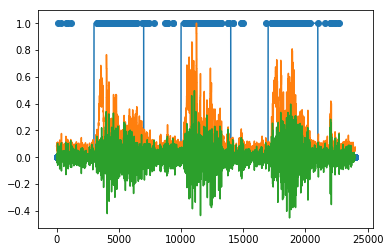

In [4]:
########################################## READ THE DATASETS #######################################################
####################### DATASET 1-2, including slip instances for pillbox object ###################################
inp = sio.loadmat(datafiles1,struct_as_record=True)
f1 = inp['f1'] # 1st optoforce
# f2 = inp['f2'] # 2nd optoforce
l1 = inp['label1'] # corresponding labels
# l2 = inp['label2']
f1d = inp['detail1'] # summary of each dataset 
lmat1 = np.zeros(f1.shape[0]) # material label
print 1,f1.shape, l1.shape, f1d.shape, lmat1.shape
################ DATASET 3, including slip instances for several surfaces (see f3d for details) ####################
inp3 = sio.loadmat(datafiles2,struct_as_record=True)
f3 = inp3['f3'] # 1st optoforce
f3 = np.array([fi[0][:,:-1] for fi in f3])[:,np.newaxis]
l31 = inp3['label3_cmd'] # corresponding label from commanded slip (1) or stay (0)
l32 = inp3['label3_vel_norm'] # corresponding measured tip velocity
l32 = np.array([ln[0]/np.max(ln[0]) for ln in l32])[:,np.newaxis]
# l33 = inp['label3_acc'] # corresponding measured tip acceleration
f3d = inp3['detail3'] # summary of each dataset
lmat3 = np.array([1,2,2,2,3,2,4]) # material label, for dataset3
print 2,f3.shape, l31.shape, f3d.shape, lmat3.shape
################ DATASET 4, including slip instances for several surfaces (see  for details) ####################
inp4 = sio.loadmat(datafiles3,struct_as_record=True)
f4 = inp4['final'] # optoforce of 2nd finger (data_format: 'experiment phase stay(1)/slip(0) fx fy fz vx vy vz')
l41 = np.array([1-fi[0][:,2][:,np.newaxis] for fi in f4])[:,np.newaxis] # commanded slip or stay
l42 = np.array([np.linalg.norm(fi[0][:,6:],axis=1)[:,np.newaxis]/np.max(np.linalg.norm(fi[0][:,6:],axis=1)[:,np.newaxis])
                for fi in f4])[:,np.newaxis] # slip or stay extracted from velocity
f4d = inp4['surf_name'][:,0][:,np.newaxis]
lmat4 = inp4['surf_lab'][:,0]
f4 = np.array([fi[0][:,3:6] for fi in f4])[:,np.newaxis]
print 3,f4.shape, l41.shape, l42.shape, f4d.shape, lmat4.shape
plt.figure(0)
plt.plot(l41[0][0])
plt.hold
plt.plot(l42[0][0])
l42accel = l42[0][0][1:]-l42[0][0][:-1]
plt.plot(l42accel)
plt.scatter(range(l42accel.shape[0]),l42accel>0.1)
########################################### MERGE THE DATASETS #####################################################
if dataset == 0: # use both datasets
    f = np.concatenate((f1,f3,f4),axis=0)
    l = np.concatenate((l1,l31,l41),axis=0)
    l2 = np.concatenate((l1,l32,l42),axis=0)
    fd = np.concatenate((f1d,f3d,f4d),axis=0)
    lmat = np.concatenate((lmat1,lmat3,lmat4),axis=0)
elif dataset == 1: # use dataset 1-2
    f = f1
    l = l1
    l2 = l1
    fd = f1d
    lmat = lmat1
elif dataset == 2:              # use dataset 3
    f = f3
    l = l31
    l2 = l32
    fd = f3d
    lmat = lmat3
elif dataset == 3:              # use dataset 4
    f = f4
    l = l41
    l2 = l42
    fd = f4d
    lmat = lmat4
print 4,f.shape,l.shape,lmat.shape
####################################### INDECES for dataset 1-2 ####################################################
# all indeces
ind = range(f.shape[0])
# indexes for rolling
indroll = [16,17,21,22] # during pure stable dataset
# indexes for disturbance
inddist = [12,26]       # ind:12 for pure stable and ind:26 for pure slip dataset 
# indexes for rotation
indrot = [25,31]        # during pure slip dataset
# indexes for circular induced slippage
indcirc = [32,33]       # during pure slip dataset
# kept indeces
if dataset == 0:
    nind = np.delete(ind,indroll+inddist)#+indrot+indcirc)
    nind = np.delete(nind,[33])
    # indexes of steady-state slip or stable
    indssbl = [0,1,2,3,12,13,14,15,16,17]
    indsslp = [18,19,20,21,22,23,24,25,26,27]
    nind = np.delete(nind,indssbl+indsslp) # remove the steady-state slip or stable indeces
else:
    nind = range(f.shape[0])
f = f[nind]
l = l[nind]
fd = fd[nind]
l2 = l2[nind]
print 5,f.shape, l.shape
# membership of each sample, representing its portion in the dataset
member = np.zeros(len(f))
m1,m3,m4 = len(nind)-len(f3)-len(f4)+1,len(f3)-1,len(f4)
member[:m1] = np.ones(m1)*1./m1
member[-m3-m4:-m4] = np.ones(m3)*1./m3
member[-m4:] = np.ones(m4)*1./m4
print 6,sum(member[:m1]),sum(member[-m3-m4:-m4]),sum(member[-m4:])
########################################### MERGE f and l ##########################################################
f = np.array([np.concatenate((f[i,0],l[i,0]),axis=1) for i in range(len(f))])
# f = np.delete(f,[33])
# fd = np.delete(fd,[33])
print 7,f.shape,":",[fi.shape for fi in f]
########################################################
f = np.array([fi[::3,:] for fi in f]) # subsampling ###
########################################################
print 8,f.shape,":",[fi.shape for fi in f]
forcename = 'forces_subsample'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
forcefile = featpath+forcename+'.npz'
np.savez(forcefile,f=f,fd=fd)
# plt.figure(1)
# plt.plot(f[33])
# plt.hold
# plt.plot(l42[4,0])

In [5]:
def make_pipe_clf(scaler,feature_selection,decomp,clf):
    order = 1
# order = 1 : first perform feature selection and then apply PCA
# order = 0 : first apply PCA and then reduce the transformed features
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                    ('classifier', clf) ])
#     else:
#         pipeline = Pipeline([('scaler', scaler),
#                     ('decomp', decomp ),                 
#                     ('feature_selection', feature_selection),        
#                     ('classifier', clf) ])
    return pipeline
###########################################################################################
def make_pipe(scaler,feature_selection,decomp,order):
    if order:
        pipeline = Pipeline([('scaler', scaler),
                    ('feature_selection', feature_selection),
                    ('decomp', decomp),         
                     ])
    else:
        pipeline = Pipeline([('scaler', scaler),
                    ('decomp', decomp ),                 
                    ('feature_selection', feature_selection),        
                     ])
    return pipeline

In [6]:
class Nested_cv:
    def __init__(self, n_outer_folds = 3, n_inner_folds = 3, n_top =1, state = 42):
        self.n_outer_folds = n_outer_folds
        self.n_inner_folds = n_inner_folds
        self.n_top = n_top
        self.state = state
#         print("constructor %d" %self.state)
                                        
    def set_pipe(self, pip_steps, pip_params):
        n_steps = len(pip_steps)
        if n_steps == 3:
            self.pipe = make_pipe(scaler = pip_steps[0], feature_selection = pip_steps[1], decomp = pip_steps[2])
            self.params = pip_params
        if n_steps == 4:
            self.pipe = make_pipe_clf(scaler = pip_steps[0], feature_selection = pip_steps[1], decomp = pip_steps[2], clf = pip_steps[3])
            self.params = pip_params
        else:
            print ("Number of steps gotta be either 3 or 4, you inserted %d." %n_steps)
        return self.pipe
        
    def fit(self, x_tot, y_tot, verbose = 0):
        self.verbose = verbose
#         print("fit %d" %self.state)
        if self.n_top >1 :
            print ("ACHTUNG! You need to use fit2 for multiple best models!")
            self.fit2(x_tot,y_tot)
        else:
            self.outer_cv = StratifiedKFold(n_splits = self.n_outer_folds, shuffle = True, random_state = self.state)
            self.inner_cv = StratifiedKFold(n_splits = self.n_inner_folds, shuffle = True, random_state = self.state)
            self.grid = GridSearchCV(self.pipe, self.params, cv = self.inner_cv, verbose = self.verbose)       
            self.score = cross_val_score(self.grid, X = x_tot, y = y_tot, cv = self.outer_cv, verbose = self.verbose)

    def get_outer_scores(self):
        return self.score
    
    def get_mean_score(self):
        self.mean_score = self.score.mean()
        print ("Mean score of %d outer folds : %f" %(self.n_outer_folds, self.mean_score ))
        return self.mean_score
    
#     def combinations(self):
#         self.comb = 1
#         for self.key in self.params.keys():
#             self.comb =self.comb*len(self.params[self.key])
#         return self.comb
    
    def get_feat_scores(self):
        return self.total_feats
    
    def get_best_features(self):
        print(self.best_feat_ind)
        return self.best_feat_ind
    
    def print_feat_scores(self):
        self.norm_total_feats = (self.total_feats)/(self.n_inner_folds * self.n_top)
        plt.figure()
        self.rel_score = plt.bar(range(len(self.total_feats)),self.norm_total_feats)
        plt.xlabel("Features")
        plt.ylabel("Score")
        plt.show()
        
    
    def repeated_cv(self,x_tot, y_tot, num_trials):
        self.repeated = np.zeros(num_trials)
        self.rep_feat_scores = np.zeros(x_tot.shape[1])
        self.num_trials = num_trials
        self.state +=1
        for st in range(self.num_trials):
            self.state +=1
            self.fit(x_tot, y_tot)
#             print("repeated %d" %self.state)
            self.out = self.get_outer_scores()
            self.rep_feat_scores += self.get_feat_scores()
            self.repeated[st] = self.out.mean()
            
        plt.figure()
        self.rep_sc_plot = plt.bar(range(num_trials),self.repeated)
        plt.xlabel("Individual trial #")
        plt.ylabel("Outer mean scores")
        plt.show()
    
    def print_rep_feat_scores(self):
        plt.figure()
        self.norm_rep_feats = (self.rep_feat_scores)/(self.n_inner_folds*self.n_top*self.num_trials)
        self.rel_score = plt.bar(range(len(self.total_feats)),self.norm_rep_feats)
        plt.xlabel("Features")
        plt.ylabel("Feature Score")
        plt.show()
        
    def get_rep_feat_scores(self):
        return self.rep_feat_scores
        
    def fit2(self,x_tot, y_tot):
        #the "handwritten" implementation
        self.total_feats = np.zeros(x_tot.shape[1])
        self.classifiers= list(ParameterGrid(self.params))
        self.outer_scores = np.zeros((self.n_top, self.n_outer_folds))
#         self.ncomp = self.params['decomp__n_components']
#         self.best_feat_ind = []
        self.best_pipes = [[],[]]
        self.outer_cv = StratifiedKFold(n_splits = self.n_outer_folds, shuffle = True, random_state = self.state)
        self.inner_cv = StratifiedKFold(n_splits = self.n_inner_folds, shuffle = True, random_state = self.state)
        self.outer = self.outer_cv.split(x_tot,y_tot)
        for self.fold_out, (self.train_ind_out,self.test_ind_out) in enumerate(self.outer):
            top_models = []
            if self.verbose>0 :
                print("Outer loop %d/%d" %((self.fold_out + 1), self.n_outer_folds))
        # split the dataset 
            self.x_trn_out, self.x_tst_out = x_tot[self.train_ind_out], x_tot[self.test_ind_out]
            self.y_trn_out, self.y_tst_out = y_tot[self.train_ind_out], y_tot[self.test_ind_out]  
            
            self.inner_scores = np.zeros((len(self.classifiers),self.n_inner_folds))
            self.inner_mean_scores = np.zeros(len(self.classifiers))
            
            for self.cl_ind, self.clf in enumerate(self.classifiers):
                self.inner = self.inner_cv.split(self.x_trn_out, self.y_trn_out)
                self.nfeat = self.classifiers[self.cl_ind]['feature_selection__k']
                self.best_feat_ind = np.zeros((self.n_top, self.nfeat))


                for self.fold_in, (self.train_ind_in, self.test_ind_in) in enumerate(self.inner): 
                    if self.verbose>0 :
                        print("Inner fold %d/%d" % ((self.fold_in + 1), self.n_inner_folds ))
                    # split the datasets for the inner cv 
                    self.x_trn_in, self.x_tst_in = self.x_trn_out[self.train_ind_in], self.x_trn_out[self.test_ind_in]
                    self.y_trn_in, self.y_tst_in = self.y_trn_out[self.train_ind_in], self.y_trn_out[self.test_ind_in]
                    self.pip = self.pipe.set_params(**self.clf)
                    self.pip.fit(self.x_trn_in,self.y_trn_in)
                    self.inner_scores[self.cl_ind][self.fold_in] = self.pip.score(self.x_tst_in, self.y_tst_in)

            # get the mean performance for every classifier
            self.inner_mean_scores = np.mean(self.inner_scores, axis = 1)
#             print('\n',self.inner_mean_scores)

            # sort the scores, low -> high 
            self.sorted_inds = self.inner_mean_scores.argsort()
            self.sorted_scores = self.inner_mean_scores[self.sorted_inds]

            print ("Best %d models for outer fold %d are: \n " %(self.n_top, (self.fold_out+1)))

#             get the inds of best performing models
            self.temp2 = 0 #iterates over n_top models
            for self.temp_ind in range(-1, -(self.n_top +1), -1):
                self.actual_ind = self.sorted_inds[self.temp_ind]
                self.best_pipes[1].append(self.classifiers[self.actual_ind]) 
                self.best_pipes[0].append(self.fold_out)
                print("model no.%d "%(self.actual_ind + 1))
                print(self.classifiers[self.actual_ind])
                #print the top features selected
                self.best_fs = self.pipe.set_params(**self.classifiers[self.actual_ind]).named_steps['feature_selection']
#                 best_fs = pipeline[actual_ind].named_steps['feature_selection']
                self.best_fs_indd = self.best_fs.get_support(indices = True)
#                 print(self.best_fs_indd)
                self.pipe_fs_unsorted = self.best_fs.scores_
                self.fs_inds = self.pipe_fs_unsorted.argsort()
#                 print(self.fs_inds)
                self.pipe_fs = self.pipe_fs_unsorted[self.fs_inds]
                self.temp3 = 0 # temp3 = 0:number of features
               
                for self.temp_ind2 in range(-1, -(self.nfeat +1), -1):         
                    self.best_feat_ind[self.temp2][self.temp3]=self.fs_inds[self.temp_ind2]
                    self.total_feats[self.fs_inds[self.temp_ind2]]+=1 # feature scores 
                    self.temp3+=1
#                 print(self.total_feats)
                #fit the best classifier on the outer test data
                self.best_pip = self.pipe.set_params(**self.classifiers[self.actual_ind])
                
                self.best_pip.fit(self.x_trn_out, self.y_trn_out)
                
                #get the outer score 
                self.outer_scores[self.temp2, self.fold_out] = self.best_pip.score(self.x_tst_out, self.y_tst_out)
                print("Inner score: %f VS Outer score: %f \n" %(self.inner_mean_scores[self.actual_ind], self.outer_scores[self.temp2, self.fold_out]))
                print ("----------------------------------------------------------")
                self.temp2+=1


#             print("Features selected: \n")
        #     print(best_feat_ind.sort())     
#             print(self.best_feat_ind)
        # print(outer_scores)  
        # print(best_pipes)
        self.score = self.outer_scores

In [7]:
def gs_fun(clf,params,cv,x,y):
    grid_search = GridSearchCV(estimator=clf,param_grid= params, cv = cv, n_jobs=-1, verbose = 0)
    grid_search.fit(x,y)
    print("------ Grid search cv results for %0.8s ------" %clf)
    print("Best score: %0.4f" %grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(params.keys()):
         print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return best_parameters, grid_search.best_estimator_

In [8]:
def ftran(f,history=20):
# Rotation of measured force wrt to contact normal frame
# Estimation of normal force at contact point assuming f
# is very close to the middle of the friction cone
    l = f[history:,-1]
    f = f[:,:-1]
    nfo = np.zeros(f[history:,:].shape)
    z = np.array([0, 0, 1])
    lastnfo = z
    currnfo = z
    retf = np.zeros(f[history:,:].shape)
#     nfo = [np.mean(f[i-history:i,:],axis=1) for i in range(len(f)) if sum(l[i-history:i]) == 0 and i>=history]  
    for i in range(len(f)):
        if i>=history:
#             print l.shape
#             print np.sum(l[i-history:i])
            if np.sum(l[i-history:i]) == 0:
                currnfo = np.mean(f[i-history:i,:],axis=0)
#                 print currnfo.shape
                currnfo /= np.linalg.norm(currnfo)
                lastnfo = currnfo
            else:
                currnfo = lastnfo
            nfo[i-history] = currnfo

            if sum(currnfo == z) == 3 or sum(currnfo == -z) == 3:
                R_cb = np.eye(3)
            else:
                R_cb = np.zeros((3, 3))
                R_cb[:, 2] = currnfo
                R_cb[:, 0] = np.cross(currnfo, z)  # x' = nfo x z
                R_cb[:, 0] = R_cb[:, 0]*1./np.sqrt(sum(np.power(R_cb[:, 0], 2)))
                R_cb[:, 1] = np.cross(currnfo, R_cb[:, 0])  # y' = nfo x x'
            R_bc = R_cb.transpose()
            newf = R_bc.dot(f[i,:])  # newf wrt contact normal's frame
            retf[i-history,:] = newf
    retf = np.concatenate((retf,l[:,np.newaxis]),axis=1)
    nfo = np.concatenate((nfo,l[:,np.newaxis]),axis=1)
    return retf, nfo

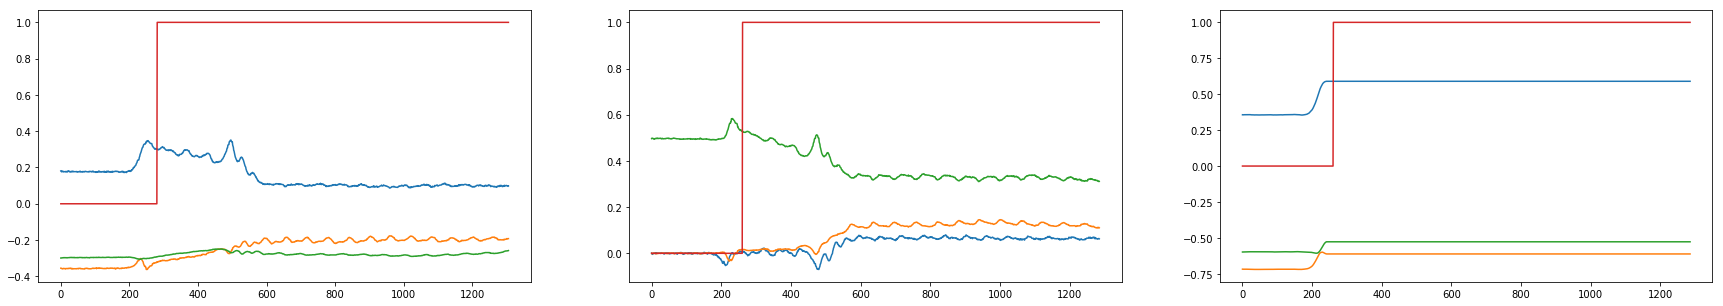

In [9]:
i = 4
plt.figure(figsize=(30,5))
plt.subplot(1,3,1)
plt.plot(f[i])
plt.subplot(1,3,2)
plt.plot(ftran(f[i])[0])
plt.subplot(1,3,3)
plt.plot(ftran(f[i])[1])

In [10]:
########################################### PRE-FEATURES ###########################################################
############# DEFINITION
# featnum 0 : sf    = (fx^2+fy^2+fz^2)^0.5
#         1 : ft    = (fx^2+fy^2)^0.5
#         2 : fn    = |fz|
#         3 : ft/fn = (fx^2+fy^2)^0.5/|fz|
# input (nxm) -> keep (nx3) -> compute pre-feature and return (nx1)
# def fnormal(f,l):
#     return 0
# def ftranslate(f,fn):
#     return 0
def sf(f):
    return np.power(np.sum(np.power(f[:,:3],2),axis=1),0.5)
def ft(f):
    return np.power(np.sum(np.power(f[:,:2],2),axis=1),0.5)
def fn(f):
    return np.abs(f[:,2])
def ftn(f):
    retft = ft(f)
    retfn = fn(f)
    retft[retfn<=1e-3] = 0
    return np.divide(retft,retfn+np.finfo(float).eps)
def lab(f):
    return np.abs(f[:,-1])
prefeatfn = np.array([sf,ft,fn,ftn,lab]) # convert to np.array to be easily indexed by a list
############# COMPUTATION
prefeatname = 'newprefeatures_trans_subsample'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
prefeatfile = featpath+prefeatname+'.npz'
prefeatfname = 'newprefeaturesfxyz_trans_subsample'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
prefeatffile = featpath+prefeatfname+'.npz'

# prefeat = np.array([np.array([f[i] for prfn in prefeatfn[prefeatid]]) for i in range(len(f))])
prefeat = np.array([np.array([prfn(f[i]) for prfn in prefeatfn[prefeatid]]).transpose() for i in range(len(f))])
print prefeat.shape,":",[p.shape for p in prefeat]
# newprefeat = np.array([np.array([ftran(f[i],l[i][0]) for prfn in prefeatfn[prefeatid]]) for i in range(len(f))])
if os.path.isfile(prefeatfile):
    newprefeat = np.load(prefeatfile)['newprefeat']
else:
    newprefeat = np.array([np.array([prfn(ftran(f[i])[0]) for prfn in prefeatfn[prefeatid]]).transpose() for i in range(len(f))])
    np.savez(prefeatfile,newprefeat=newprefeat)
print newprefeat.shape,":",[p.shape for p in newprefeat]
if os.path.isfile(prefeatffile):
    newprefeatf = np.load(prefeatffile)['newprefeatf']
else:
    newprefeatf = np.array([ftran(f[i])[0] for i in range(len(f))])
    np.savez(prefeatffile,newprefeatf=newprefeatf)
# newprefeat = np.array([Parallel(n_jobs=-1)([delayed(function)(orisma)(np.array([prfn(ftran(f[i],l[i][0])) for prfn in prefeatfn[prefeatid]]).transpose()) for i in range(len(f))])])
# np.array([Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])])
print newprefeatf.shape,":",[p.shape for p in newprefeatf]

(29,) : [(428, 3), (1303, 3), (704, 3), (680, 3), (1306, 3), (2046, 3), (2031, 3), (823, 3), (13340, 3), (13332, 3), (13335, 3), (13284, 3), (13316, 3), (13299, 3), (8000, 3), (7000, 3), (6834, 3), (6834, 3), (7834, 3), (8000, 3), (8000, 3), (8000, 3), (8000, 3), (8000, 3), (8000, 3), (9000, 3), (9167, 3), (9167, 3), (9167, 3)]
(29,) : [(408, 3), (1283, 3), (684, 3), (660, 3), (1286, 3), (2026, 3), (2011, 3), (803, 3), (13320, 3), (13312, 3), (13315, 3), (13264, 3), (13296, 3), (13279, 3), (7980, 3), (6980, 3), (6814, 3), (6814, 3), (7814, 3), (7980, 3), (7980, 3), (7980, 3), (7980, 3), (7980, 3), (7980, 3), (8980, 3), (9147, 3), (9147, 3), (9147, 3)]
(29,) : [(408, 4), (1283, 4), (684, 4), (660, 4), (1286, 4), (2026, 4), (2011, 4), (803, 4), (13320, 4), (13312, 4), (13315, 4), (13264, 4), (13296, 4), (13279, 4), (7980, 4), (6980, 4), (6814, 4), (6814, 4), (7814, 4), (7980, 4), (7980, 4), (7980, 4), (7980, 4), (7980, 4), (7980, 4), (8980, 4), (9147, 4), (9147, 4), (9147, 4)]


(9167, 3) (9147, 3)


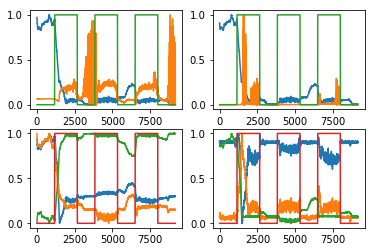

In [11]:
i = -1
print prefeat[i].shape, newprefeat[i].shape
plt.subplot(2,2,1)
plt.plot(prefeat[i]/np.max(prefeat[i],axis=0))
plt.subplot(2,2,2)
plt.plot(newprefeat[i]/np.max(newprefeat[i],axis=0))
plt.subplot(2,2,3)
plt.plot((f[i]-np.min(f[i],axis=0))/(np.max(f[i],axis=0)-np.min(f[i],axis=0)))
plt.subplot(2,2,4)
plt.plot((newprefeatf[i]-np.min(newprefeatf[i],axis=0))/(np.max(newprefeatf[i],axis=0)-np.min(newprefeatf[i],axis=0)))

In [12]:
# plt.figure(figsize=(50,80))
# for i in range(prefeat.shape[0]):
#     plt.subplot(10,5,i+1)
#     plt.plot(prefeat[i]/np.max(prefeat[i],axis=0))

(29,) : [(408, 3), (1283, 3), (684, 3), (660, 3), (1286, 3), (2026, 3), (2011, 3), (803, 3), (13320, 3), (13312, 3), (13315, 3), (13264, 3), (13296, 3), (13279, 3), (7980, 3), (6980, 3), (6814, 3), (6814, 3), (7814, 3), (7980, 3), (7980, 3), (7980, 3), (7980, 3), (7980, 3), (7980, 3), (8980, 3), (9147, 3), (9147, 3), (9147, 3)]


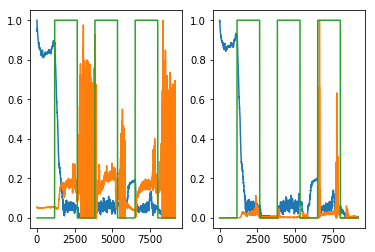

In [13]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(prefeat[-2]/np.max(prefeat[-2],axis=0))
plt.subplot(1,2,2)
plt.plot(newprefeat[-2]/np.max(newprefeat[-2],axis=0))
prefeat = newprefeat
print prefeat.shape,":",[p.shape for p in prefeat]

In [14]:
# i=0
# tmpin = prefeat[30][i:i+window,:2]
# # IS = intsgnl(tmpin)
# # MA = meanabs(tmpin)
# MF = mf(tmpin)
# # print IS, MA
# # for j in MF[:-1]:
# #     print j.shape
# # print MF[-1], "------------"
# t1 = time.time()
# featparam1 = [0,featlabel,magnFFT,featall,1]
# tmpfeat, tinit = feat(prefeat[30][i:i+window,:2],*featparam1)
# print tmpfeat.shape, tinit, (tinit - t1)*1000
# # print tmpfeat[0,0].shape, tmpfeat[0,1]
# # t2 = tmpfeat[13][1]
# # t = t2
# # print (tinit - t1)*1000
# # for i in tmpfeat[:,0]:
# #     print i[0], i[1]
# #     if i[0].shape[0]>5:
# #         t = t1
# #     print i[0].shape, (i[1]-t)*1000
# #     if i[0].shape[0]<5:
# #         t = i[1]

In [15]:
############################# Computation time of ALL features in secs #############################################
t1 = time.time()
tmpfeat = [feat(prefeat[15][i:i+window,:2],*featparam) for i in range(100)] # avg over 100 times
print (time.time()-t1)/100

0.00105185985565


In [16]:
# tall = []
# for j in range(100):
#     tall.append([])
#     t1 = time.time()
#     tmpfeat, tinit = feat(prefeat[30][j:j+window,:2],*featparam1)
#     t2 = tmpfeat[13][1]
#     t = t2
#     tall[j].append((tinit - t1)*1000)
#     for i in tmpfeat:
#         if i[0].shape[0]>5:
#             t = t1
# #         print i[0].shape, (i[1]-t)*1000
#         tall[j].append((i[1] - t)*1000)
#         if i[0].shape[0]<5:
#             t = i[1]
# tall = np.array(tall)
# print tall.shape, np.mean(tall,axis=0)#, np.sum(tall[:,1:],axis=1)-tall[:,0]

In [17]:
# mu_approx = []
# mu_approx2 = []
# mu_approx3 = []
# history = 20
# for i in range(len(prefeat)):
#     tmpd = np.abs(np.diff(prefeat[i][:,-1],n=1,axis=0))
#     if np.sum(tmpd) > 0:
#         tmpind = np.array(range(len(tmpd)))[tmpd > 0]
#         print i, prefeat[i].shape, np.sum(tmpd), tmpind
#         tmpindrng = []
#         for j in range(len(tmpind)):
#             k = 0.1
#             length = int(round(k*prefeat[i].shape[0]))
#             tmprng = np.array(range(tmpind[j]-length,tmpind[j]+length))
# #             print j, tmprng
#             tmprng = tmprng[tmprng>=0]
#             tmprng = tmprng[tmprng<length/k]
#             tmpindrng.append(tmprng.tolist())
#         tmpindrng = np.array(tmpindrng).flatten()
# #         print tmpindrng
#         tmp_mu = prefeat[i][tmpindrng,1]
#         tmprng2 = np.logical_and((prefeat[i][1:,1]-prefeat[i][:-1,1])>0.01, (prefeat[i][1:,1]-prefeat[i][:-1,1])<1.5)
# #         print tmprng2.shape
# #         tmpindrng2 = np.empty(prefeat[i].shape[0], dtype=bool)
# #         tmpindrng2.fill(0)
# #         tmpindrng2[tmpindrng] = True
#         tmpindrng2 = np.insert(tmprng2,0,tmprng2[0])
# #         print tmpindrng2.shape, prefeat[i].shape, tmpindrng2
#         tmp_mu2 = prefeat[i][tmpindrng2,1]
# #===== mu3 approximation considering velocity
#         if np.sum(tmpd) > 1:
#             mean_stbl_vel = np.mean(l2[i][0][l[i][0]==0])
#             mean_slip_vel = np.mean(l2[i][0][l[i][0]==1])
#             tmpindrng3 = np.empty(prefeat[i].shape[0], dtype=bool)
#             tmpindrng3.fill(0)
#             tmprng3 = np.logical_and(l2[i][0]>=1.25*mean_stbl_vel,l2[i][0]<=0.75*mean_slip_vel)
#             tmpindrng3[tmprng3[history:,0]] = True
#             tmp_mu3 = prefeat[i][tmpindrng3,1]
#             mu_approx3.append(tmp_mu3)
#         else:
#             mu_approx3.append(np.array([1.0]))
# #=====
    
# #         print tmp_mu, tmp_mu2
#         mu_approx.append(tmp_mu)
#         mu_approx2.append(tmp_mu2)
# #         plt.figure()
# #         plt.plot(np.diff(prefeat[i][:,-1],n=1,axis=0))
# #         plt.hold
# #         plt.plot(prefeat[i][:,-1])
#     else:
#         mu_approx.append(np.array([1.0]))
#         mu_approx2.append(np.array([1.0]))
#         mu_approx3.append(np.array([1.0]))
# # print mu_approx
# meanmu = [np.mean(mu) for mu in mu_approx]
# meanmu2 = [np.mean(mu) for mu in mu_approx2]
# meanmu3 = [np.mean(mu) for mu in mu_approx3]
# print meanmu, meanmu2, meanmu3

In [18]:
# newlabel = deepcopy(l)
# for i in range(len(l)):
# #     print i, meanmu3[i]
#     if meanmu3[i] != 1.0:
#         plt.figure()
#         plt.plot(l[i][0])
#         plt.hold
#         newlabel[i][0][history:,0] = prefeat[i][:,1]>=meanmu3[i]
#         plt.plot(newlabel[i][0])

0 (408,) (408, 3)
1 (1283,) (1283, 3)
2 (684,) (684, 3)
3 (660,) (660, 3)
4 (1286,) (1286, 3)
5 (2026,) (2026, 3)
6 (2011,) (2011, 3)
7 (803,) (803, 3)
8 (13320,) (13320, 3)
9 (13312,) (13312, 3)
10 (13315,) (13315, 3)
11 (13264,) (13264, 3)
12 (13296,) (13296, 3)
13 (13279,) (13279, 3)
14 (7980,) (7980, 3)
15 (6980,) (6980, 3)
16 (6814,) (6814, 3)
17 (6814,) (6814, 3)
18 (7814,) (7814, 3)
19 (7980,) (7980, 3)
20 (7980,) (7980, 3)
21 (7980,) (7980, 3)
22 (7980,) (7980, 3)
23 (7980,) (7980, 3)
24 (7980,) (7980, 3)
25 (8980,) (8980, 3)
26 (9147,) (9147, 3)
27 (9147,) (9147, 3)
28 (9147,) (9147, 3)


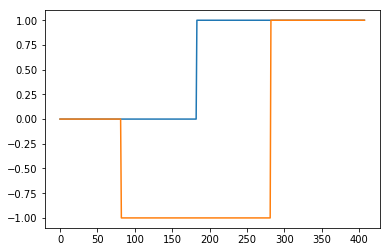

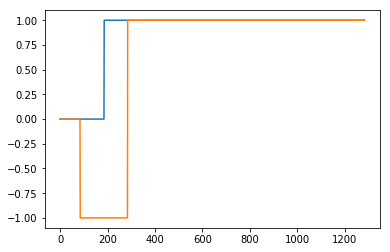

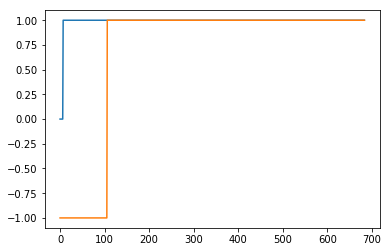

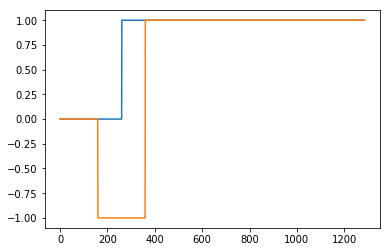

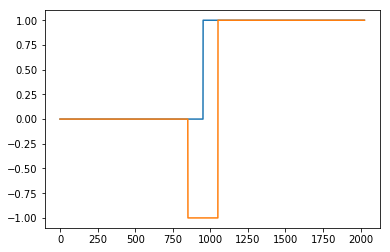

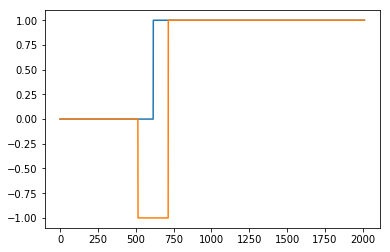

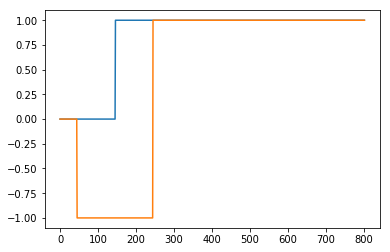

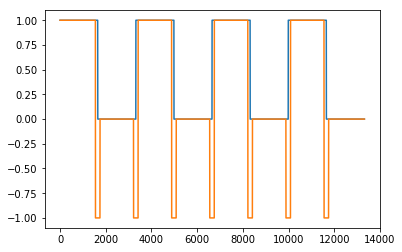

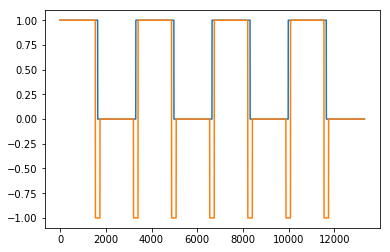

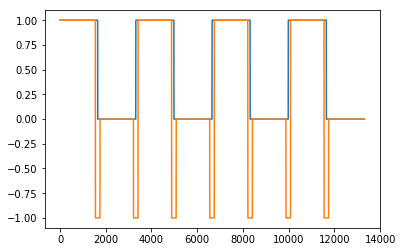

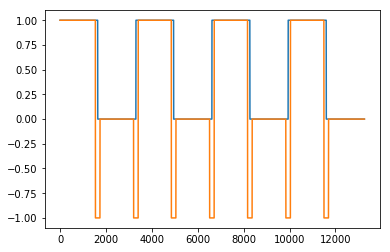

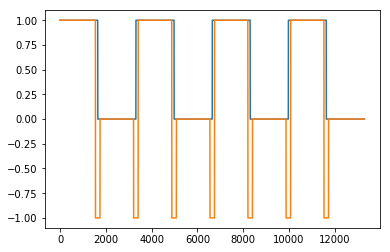

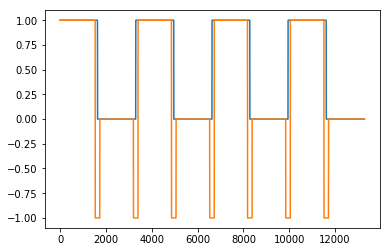

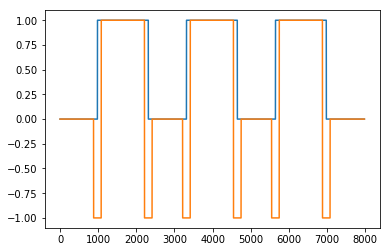

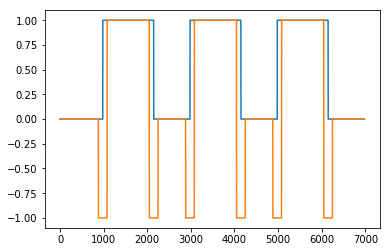

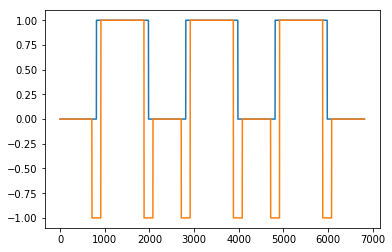

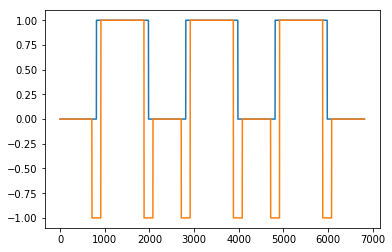

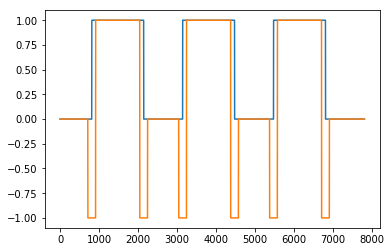

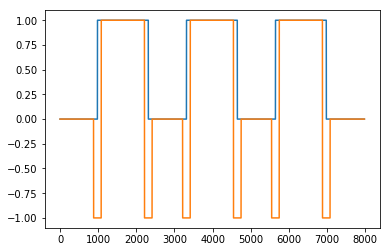

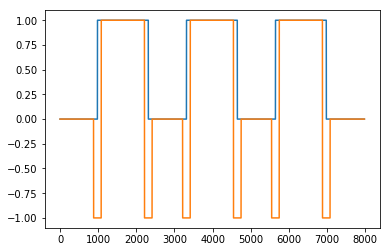

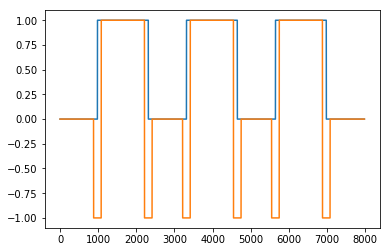

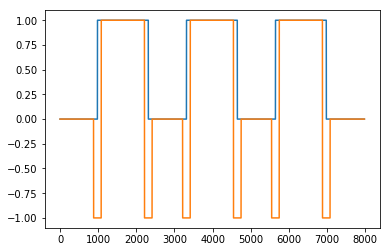

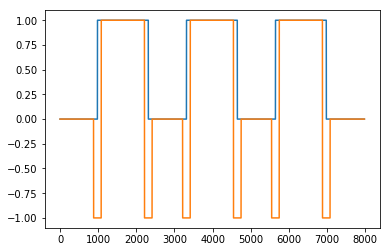

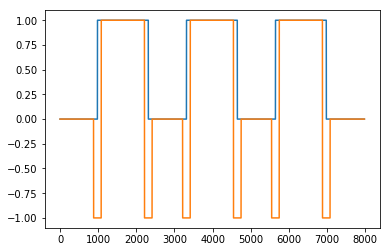

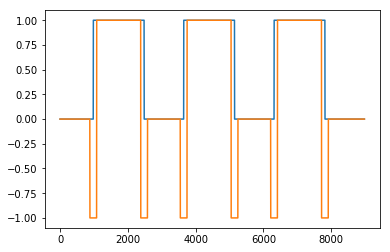

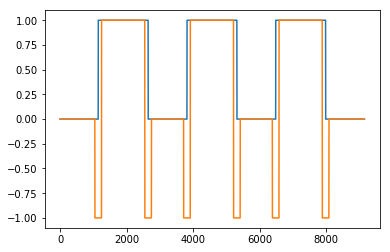

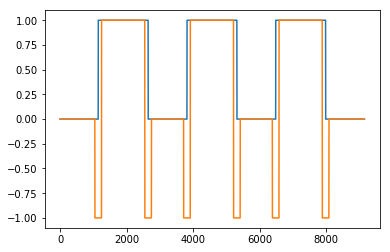

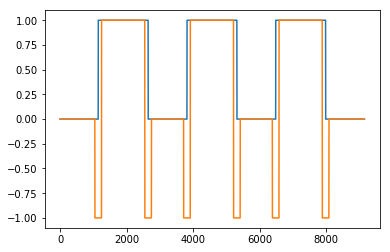

In [30]:
# ####======= Code for keeping as much as possible only the pure stable and slip parts of label 
lbl_approx = []
history = 100
for i in range(len(prefeat)):
    tmpd = np.abs(np.diff(prefeat[i][:,-1],n=1,axis=0))
    if np.sum(tmpd) > 0:
        # find the sign change points
        tmpind = np.array(range(len(tmpd)))[tmpd > 0]
#         print i, prefeat[i].shape, np.sum(tmpd), tmpind
        tmpindrng = []
        for j in range(len(tmpind)):
            # keep/throw a portion of the signal's length around change points
            length = history
            tmprng = np.array(range(tmpind[j]-length,tmpind[j]+length))
            # make sure inside singal's x-range
            tmprng = tmprng[tmprng>=0]
            tmprng = tmprng[tmprng<prefeat[i].shape[0]]
            tmpindrng.append(tmprng.tolist())
        tmpindrng = np.array(tmpindrng).flatten()
        tmp_lbl = deepcopy(prefeat[i][:,-1])
        tmp_lbl[tmpindrng] = -1
        lbl_approx.append(tmp_lbl)
        plt.figure()
        plt.plot(prefeat[i][:,-1])
        plt.hold
        plt.plot(lbl_approx[-1][:])
    else:
        lbl_approx.append(prefeat[i][:,-1])
for i in range(len(lbl_approx)):
    print i, lbl_approx[i].shape, prefeat[i].shape

In [31]:
############################################# FEATURE COMPUTATION ##################################################
# featname = 'newfeatures'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
# featname = 'newfeatures_trans'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
# featfile = featpath+featname+'.npz'
# XYfile = featpath+featname+'_XY.npz'
# XYnormfile = featpath+featname+'_XYnorm.npz'
# def tmpfeatfilename(p,mode='all'):
#     if mode == 'all':
#         return featpath+'allfeats/'+'feat'+str(p)+'.pkl.z'
#     elif mode == 'red':
#         return featpath+'allfeats/'+'feat'+str(p)+'red'+str(samplesperdataset)+'.pkl.z'
def tmpfeatfilename(p,mode='all'):
    if mode == 'all':
        return featpath+'allfeats/'+'feat_tran_subsmaple'+str(p)+'.pkl.z'
    elif mode == 'red':
        return featpath+'allfeats/'+'feat_tran_subsample'+str(p)+'red'+str(samplesperdataset)+'.pkl.z'
if os.path.isfile(XYfile):
    print "Continuing to XY values..."
else:
    if os.path.isfile(featfile):
        start_time = time.time()
        features = np.load(featfile)['features']
        labels = np.load(featfile)['labels']
        print("Features FOUND PRECOMPUTED! Feature Loading DONE in: %s seconds " % (time.time() - start_time))
    else:
        start_time = time.time()
        features = []
        labels = []
        for ixp in range(len(prefeat)):
            p = prefeat[ixp]
            now = time.time()
            tmpfn = tmpfeatfilename(ixp)
            tmpfnred = tmpfeatfilename(ixp,'red')
            if not os.path.isfile(tmpfnred):
                if not os.path.isfile(tmpfn):
                    # Computation of all features in parallel by all cores
                    tmp = np.array([Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])])
                    with open(tmpfn,'wb') as fo:
                        joblib.dump(tmp,fo)
                    print ixp, time.time()-now, tmpfn, tmp.shape
                else:
                    with open(tmpfn,'rb') as fo:
                        tmp = joblib.load(fo)
                    print ixp, time.time()-now, tmpfn, ' already here!', tmp.shape
                # keep less from each feature vector but keep number of samples for each dataset almost equal
                #tmpskip = int(round(tmp.shape[1]/200.))
                tmpskip = int(round(tmp.shape[1]/(member[ixp]*samplesperdataset)))
                if tmpskip == 0: 
                    tmpskip = 1
#                 print tmp.shape, member[ixp], tmpskip
                # Save reduced size features
                print tmp.shape
                tmp = tmp[0,::tmpskip,:,:]
                with open(tmpfnred,'wb') as fo:
                    joblib.dump(tmp,fo)
                print ixp, time.time()-now, tmpfnred, tmp.shape
        for ixp in range(len(prefeat)):  
            tmpfnred = tmpfeatfilename(ixp,'red')
            with open(tmpfnred,'rb') as fo:
                tmp = joblib.load(fo)
            print ixp, time.time()-now, tmpfnred, 'already here!', tmp.shape
            features.append(tmp[:,:,:2])
            labels.append(tmp[:,0,2])
            #features.append(tmp[0,::tmpskip,:,:2])
            #labels.append(tmp[0,::tmpskip,0,2])
            #print np.array(features.shape), np.array(labels.shape)
            #print 'features: ',np.array(features).shape,[f.shape for f in features]
            #print 'labels: ', np.array(labels).shape,[l.shape for l in labels]
        #allfeatures = [Parallel(n_jobs=4)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)]) for p in prefeat[:-7]]
        #allfeatures = [[feat(p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)] for p in prefeat[:-7]]
        #allfeatures = [[feat(p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)] for p in prefeat[-7:]]
        #print 'allfeatures: ',allfeatures.shape
        print("Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: %s seconds " % (time.time() - start_time))
        #raw_input()
        #features = np.array([np.array(fi)[:,:,:-1] for fi in allfeatures])
        #labels = np.array([np.array(fi)[:,0,-1] for fi in allfeatures])
        features = np.array(features)
        # ommit the last computed feature ffaf, which consumes most of computation time
#         features = np.array([ftmp[:,:-1,:] for ftmp in features])
        labels = np.array(labels)
        print 'features: ',features.shape,[ftmp.shape for ftmp in features]
        print 'labels: ', labels.shape,[l.shape for l in labels]
        #print("Features NOT FOUND PRECOMPUTED! Feature Computation DONE in: %s seconds " % (time.time() - start_time))
        np.savez(featfile,features=features,labels=labels)
        #sio.savemat(featpath+featname+'.mat',mdict={'features': features,'labels': labels})
    print features.shape, labels.shape
    for i in range(features.shape[0]):
        print i, np.array(features[i]).shape, np.array(labels[i]).shape

Features FOUND PRECOMPUTED! Feature Loading DONE in: 0.381708145142 seconds 
(29,) (29,)
0 (152, 803, 2) (152,)
1 (1027, 803, 2) (1027,)
2 (428, 803, 2) (428,)
3 (404, 803, 2) (404,)
4 (1030, 803, 2) (1030,)
5 (1770, 803, 2) (1770,)
6 (1755, 803, 2) (1755,)
7 (547, 803, 2) (547,)
8 (1633, 803, 2) (1633,)
9 (1632, 803, 2) (1632,)
10 (1633, 803, 2) (1633,)
11 (1626, 803, 2) (1626,)
12 (1630, 803, 2) (1630,)
13 (1628, 803, 2) (1628,)
14 (644, 803, 2) (644,)
15 (673, 803, 2) (673,)
16 (656, 803, 2) (656,)
17 (656, 803, 2) (656,)
18 (688, 803, 2) (688,)
19 (644, 803, 2) (644,)
20 (644, 803, 2) (644,)
21 (644, 803, 2) (644,)
22 (644, 803, 2) (644,)
23 (644, 803, 2) (644,)
24 (644, 803, 2) (644,)
25 (672, 803, 2) (672,)
26 (684, 803, 2) (684,)
27 (684, 803, 2) (684,)
28 (684, 803, 2) (684,)


In [32]:
if os.path.isfile(featfile):
    start_time = time.time()
    features = np.load(featfile)['features']
    labels = np.load(featfile)['labels']
    print("Features FOUND PRECOMPUTED! Feature Loading DONE in: %s seconds " % (time.time() - start_time))
else:
    print("Features NOT FOUND BUT SHOULD BE precomputed! DO something about it!")
print features.shape, labels.shape
for i in range(features.shape[0]):
    print i, np.array(features[i]).shape, np.array(labels[i]).shape

Features FOUND PRECOMPUTED! Feature Loading DONE in: 0.395534038544 seconds 
(29,) (29,)
0 (152, 803, 2) (152,)
1 (1027, 803, 2) (1027,)
2 (428, 803, 2) (428,)
3 (404, 803, 2) (404,)
4 (1030, 803, 2) (1030,)
5 (1770, 803, 2) (1770,)
6 (1755, 803, 2) (1755,)
7 (547, 803, 2) (547,)
8 (1633, 803, 2) (1633,)
9 (1632, 803, 2) (1632,)
10 (1633, 803, 2) (1633,)
11 (1626, 803, 2) (1626,)
12 (1630, 803, 2) (1630,)
13 (1628, 803, 2) (1628,)
14 (644, 803, 2) (644,)
15 (673, 803, 2) (673,)
16 (656, 803, 2) (656,)
17 (656, 803, 2) (656,)
18 (688, 803, 2) (688,)
19 (644, 803, 2) (644,)
20 (644, 803, 2) (644,)
21 (644, 803, 2) (644,)
22 (644, 803, 2) (644,)
23 (644, 803, 2) (644,)
24 (644, 803, 2) (644,)
25 (672, 803, 2) (672,)
26 (684, 803, 2) (684,)
27 (684, 803, 2) (684,)
28 (684, 803, 2) (684,)


In [33]:
# ======= Code for keeping as much as possible only the pure stable and slip parts of label after feature extraction 
new_labels = deepcopy(labels)
for ixp in range(len(lbl_approx)):
    p = lbl_approx[ixp]
    tmp = np.array([p[k+window] for k in range(0,len(p)-window,shift)])
#     print ixp, tmp.shape
    tmpskip = int(round(tmp.shape[0]/(member[ixp]*samplesperdataset)))
    if tmpskip == 0: 
        tmpskip = 1
    #                 print tmp.shape, member[ixp], tmpskip
    # Save reduced size features
    tmp = tmp[::tmpskip]
    new_labels[ixp] = tmp
    print ixp, tmp.shape, labels[ixp].shape
# print new_labels.shape

0 (152,) (152,)
1 (1027,) (1027,)
2 (428,) (428,)
3 (404,) (404,)
4 (1030,) (1030,)
5 (1770,) (1770,)
6 (1755,) (1755,)
7 (547,) (547,)
8 (1633,) (1633,)
9 (1632,) (1632,)
10 (1633,) (1633,)
11 (1626,) (1626,)
12 (1630,) (1630,)
13 (1628,) (1628,)
14 (644,) (644,)
15 (673,) (673,)
16 (656,) (656,)
17 (656,) (656,)
18 (688,) (688,)
19 (644,) (644,)
20 (644,) (644,)
21 (644,) (644,)
22 (644,) (644,)
23 (644,) (644,)
24 (644,) (644,)
25 (672,) (672,)
26 (684,) (684,)
27 (684,) (684,)
28 (684,) (684,)


In [34]:
# nfeatures = deepcopy(features)
# new labels are the original without the transition phases!!!!
labels = new_labels
# for i in range(features.shape[0]):
# #     print i, np.array(nfeatures[i]).shape, np.array(labels[i]).shape
#     features[i] = np.concatenate((features[i][:,:,0],features[i][:,:,1]),axis=1)
#     print i, np.array(features[i]).shape, np.array(labels[i]).shape

In [35]:
### GATHER ALL FEATURES TOGETHER and NORMALIZE THEM ######################################
############# GATHERING features and labels into one array each
if os.path.isfile(XYfile):
    print "Continuing to XY values..."
else:
    #features = features[:,::keepfromshift,:]
    #labels = labels[:,::keepfromshift,:]
    ind,feats = {},{}
    l_ind = [0,0,0]
    ind[2] = range(features.shape[0])                                      # indeces for all datasets
#     print features.shape, len(ind[2]), int(round(len(ind[2])*1./samplesperdataset))
#     ind[2] = ind[2][::int(round(len(ind[2])*1./samplesperdataset))]
    ind[0] = range(features.shape[0])[:m1+m3]                                 # indeces for pillbox dataset12
#     ind[0] = ind[0][::int(round(len(ind[0])*1./samplesperdataset))]
    ind[1] = range(features.shape[0])[-m4:]                          # indeces or different surfaces dataset3
#     ind[1] = ind[1][::int(round(len(ind[1])*1./samplesperdataset))]
    ind = np.array([i for _,i in ind.items()])
    feats[0] = features[ind[0]]                                              # features for pillbox
    feats[1] = features[ind[1]]
    feats[2] = features[ind[2]]                                            # features for differ. surfaces
    print 'prefeats: ',feats[0].shape, feats[1].shape, feats[2].shape
#     feats[2] = np.concatenate(features,axis=0)                                # all features together
    feats[2] = np.concatenate(feats[2],axis=0)
    print feats[2].shape#,int(round(feats[2].shape[0]*1./samplesperdataset))
    l_ind[2] = feats[2].shape[0]
    feats[2] = np.array([feats[2][:,:,i] for i in range(feats[2].shape[2])])
    feats[2] = feats[2][:,::int(round(feats[2].shape[1]*1./samplesperdataset)),:]
    print feats[2].shape
    feats[0] = np.concatenate(feats[0],axis=0)
    print feats[0].shape#,int(round(feats[0].shape[0]*1./samplesperdataset))
    l_ind[0] = feats[0].shape[0]
    feats[0] = np.array([feats[0][:,:,i] for i in range(feats[0].shape[2])])
    feats[0] = feats[0][:,::int(round(feats[0].shape[1]*1./samplesperdataset)),:]
    print feats[0].shape
    feats[1] = np.concatenate(feats[1],axis=0)
    print feats[1].shape#,int(round(feats[1].shape[0]*1./samplesperdataset))
    l_ind[1] = feats[1].shape[0]
    feats[1] = np.array([feats[1][:,:,i] for i in range(feats[1].shape[2])])
    feats[1] = feats[1][:,::int(round(feats[1].shape[1]*1./samplesperdataset)),:]
    print feats[1].shape
    feats = [i for _,i in feats.items()]
    print 'feats: ',feats[0].shape, feats[1].shape, feats[2].shape
    labs = np.concatenate(labels,axis=0)
    print 'labs: ',labs.shape

prefeats:  (14,) (15,) (29,)
(26800, 803, 2)
(2, 8934, 803)
(16895, 803, 2)
(2, 8448, 803)
(9905, 803, 2)
(2, 9905, 803)
feats:  (2, 8448, 803) (2, 9905, 803) (2, 8934, 803)
labs:  (26800,)


In [36]:
############# GATHERING into one complete array
if os.path.isfile(XYfile):
    X = np.load(XYfile)['X']
    Y = np.load(XYfile)['Y']
else:
    X,Y = {},{}
#     ind[2] = np.array(range(feats[0].shape[1]+feats[1].shape[1],feats[0].shape[1]+feats[1].shape[1]+feats[2].shape[1]))
#     ind[2] = np.array(range(feats[2].shape[1]))
    ind[2] = np.array(range(l_ind[2]))
    ind[2] = ind[2][::int(round(len(ind[2])*1./samplesperdataset))]
    ind[0] = np.array(range(l_ind[0]))                               # indeces for pillbox dataset12
    ind[0] = ind[0][::int(round(len(ind[0])*1./samplesperdataset))]
    ind[1] = np.array(range(l_ind[0],l_ind[0]+l_ind[1]))
    ind[1] = ind[1][::int(round(len(ind[1])*1./samplesperdataset))]
    print ind[0].shape, ind[1].shape, ind[2].shape, feats[0].shape, feats[1].shape, feats[2].shape
#     raw_input()
    X[2],Y[2] = np.concatenate([feats[2][i] for i in range(feats[2].shape[0])],axis=1),labs[ind[2]]
    print X[2].shape, Y[2].shape
    X[0],Y[0] = np.concatenate([feats[0][i] for i in range(feats[0].shape[0])],axis=1),labs[ind[0]]
    print X[0].shape, Y[0].shape
    X[1],Y[1] = np.concatenate([feats[1][i] for i in range(feats[1].shape[0])],axis=1),labs[ind[1]]
    print X[1].shape, Y[1].shape
    X = np.array([i for _,i in X.items()])
    Y = np.array([i for _,i in Y.items()])
    np.savez(XYfile,X=X,Y=Y)
print 'gathered features: ', X[0].shape, Y[0].shape, X[1].shape, Y[1].shape, X[2].shape, Y[2].shape, np.sum(Y[2])

(8448,) (9905,) (8934,) (2, 8448, 803) (2, 9905, 803) (2, 8934, 803)
(8934, 1606) (8934,)
(8448, 1606) (8448,)
(9905, 1606) (9905,)
gathered features:  (8448, 1606) (8448,) (9905, 1606) (9905,) (8934, 1606) (8934,) 3717.0


In [37]:
# %%time
# # upologismos twn nodes
# # to 28 menei gia to testing

# cols = features[0].shape[1]
# # features = deepcopy(cwt_data)
# from_d = 0
# # from_r = [int(np.ceil(0.0*features[i].shape[0])) for i in range(from_d,len(features))]
# # to_r = [int(np.ceil(1.0*features[i].shape[0])) for i in range(from_d,len(features))]

# X_train = [features[i+from_d] for i in range(len(features))]
# Y_train = [labels[i+from_d] for i in range(len(features))]

# print len(X_train), len(Y_train)

# # clf = [SVC(kernel = 'rbf', C = 10) for i in range(len(X_train))]
# clf = [KNeighborsClassifier(n_neighbors=7) for i in range(len(X_train))]
# feat_sel = [SelectKBest(k=50, score_func= mutual_info_classif) for i in range(len(X_train))]
# sca = [StandardScaler() for i in range(len(X_train))]
# pipe = [Pipeline([('scaler', sca[i]),('feat_sel', feat_sel[i]),('clf',clf[i])]) for i in range(len(X_train))]
# # asd = [print(X_train[i].shape) for i in range(len(X_train))]
# # nodes = [pipe[i].fit(X_train[i],Y_train[i]) for i in range(len(X_train))]
# nodes = Parallel(n_jobs=-1)([delayed(pipe[i].fit) (X_train[i], Y_train[i]) for i in range(len(X_train))])
# print len(nodes)

In [38]:
# # output will be calculated by a simple majority vote.
# # ONLY THE LAST LABEL WILL BE KEPT 
# def nodes_pred(X_test, nodes):
#     Y_pred = [nodes[i].predict(X_test) for i in range(len(nodes))]
#     Y_vote = np.zeros(X_test.shape[0])
#     for i in range(X_test.shape[0]): # for every point in X_test 
#         votes = np.zeros(2)
#         for j in range(len(Y_pred)): # for every node 
#             if (Y_pred[j][i]==1.):
#                 votes[1]+=1
#             else:
#                 votes[0]+=1
#             Y_vote[i] = np.argmax(votes)
#     return Y_vote
# #     return Y_vote[-1]

In [39]:
# if os.path.isfile(XYfile):
#     X = np.load(XYfile)['X']
#     Y = np.load(XYfile)['Y']
#     print 'gathered features: ', X[0].shape, Y[0].shape, X[1].shape, Y[1].shape, X[2].shape, Y[2].shape
# else:
#     print("XYfile NOT FOUND BUT SHOULD BE precomputed! DO something about it!")

In [40]:
# # simulating the online procedure with input of size 1024
# X_test = X[2]
# Y_test = Y[2]
# wind = 25
# test_batches = np.arange(0,X_test.shape[0],wind)
# x_batch = [X_test[batch:batch+wind,:] for batch in test_batches]
# y_batch = [Y_test[batch:batch+wind] for batch in test_batches]
# average_score = np.zeros(len(test_batches))

# for batch_id,batch in enumerate(test_batches):
#     Y_vot = nodes_pred(X_test = x_batch[batch_id],nodes = nodes)
#     Y_vot1 = Y_vot[-1]
#     average_score[batch_id] = np.abs(Y_vot1-y_batch[batch_id][-1]) 
#     print '\r Batch no:%d out of %d ' %(batch_id,len(test_batches)-1),
    
# print('\n Average error for %d batches = %f' %(len(test_batches),np.mean(average_score)))
# print("Missclasifed instances: %d/%d" %(np.count_nonzero(average_score == 1), len(average_score)))

In [41]:
# # %%time
# #  kuklikh enallagh en eidei cv metaksu twn datasets
# # X_train = X[2]
# from_d = 0
# coefs = features.tolist()
# # from_r = [int(np.ceil(0.1*coefs[i].shape[0])) for i in range(from_d,len(coefs))]
# # to_r = [int(np.ceil(0.9*coefs[i].shape[0])) for i in range(from_d,len(coefs))]
# datas = range(from_d,len(coefs))
# for dat in datas:
#     coefs_test = coefs[dat]
#     coefs_train = coefs[from_d:dat]+coefs[dat+1:]
#     labels_train = labels.tolist()[from_d:dat]+labels.tolist()[dat+1:]
#     print('Training on', [i for i in range(from_d,dat)]+[i for i in range(dat+1,len(coefs))])
#     print('Testing on', dat)
#     X_train = [coefs_train[train_ind] for train_ind in range(len(coefs_train))]
#     Y_train = [labels[train_ind] for train_ind in range(len(labels_train))]
#     X_test = coefs_test
#     Y_test = labels.tolist()[dat]
# #     clf = [SVC(kernel = 'rbf', C = 100) for i in range(len(X_train))]
#     clf = [KNeighborsClassifier(n_neighbors=7) for i in range(len(X_train))]
#     feat_sel = [SelectKBest(k=50, score_func= mutual_info_classif) for i in range(len(X_train))]
#     sca = [StandardScaler() for i in range(len(X_train))]
#     pipe = [Pipeline([('scaler', sca[i]),('feat_sel', feat_sel[i]),('clf',clf[i])]) for i in range(len(X_train))]
#     # asd = [print(X_train[i].shape) for i in range(len(X_train))]
#     # nodes = [pipe[i].fit(X_train[i],Y_train[i]) for i in range(len(X_train))]
#     nodes = Parallel(n_jobs=-1)([delayed(pipe[i].fit) (X_train[i], Y_train[i]) for i in range(len(X_train))])

#     y_voted = nodes_pred(X_test, nodes)
#     cm = confusion_matrix(y_pred=y_voted, y_true=Y_test)
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)
#     print(classification_report(y_pred=y_voted, y_true = Y_test))

    

# clf = [SVC(kernel = 'rbf', C = 100, gamma = 0.2) for i in range(len(X_train))]

# asd = [print(X_train[i].shape) for i in range(len(X_train))]
# nodes = [clf[i].fit(X_train[i],Y_train[i]) for i in range(len(X_train))]

In [45]:
# ############################ XY file for split feature sets and filtered label ###################################
XYsplitfile = featpath+featname+'_XYsplit.npz'
tmpind = {}
tmpind[2] = range(X[0].shape[1])
tmpind[0] = range(X[0].shape[1]/2)
tmpind[1] = range(X[0].shape[1]/2,X[0].shape[1])
tmpind = np.array([i for _,i in tmpind.items()])
keepind = np.zeros((X.shape[0])).tolist()
if os.path.isfile(XYsplitfile):
    Xsp = np.load(XYsplitfile)['Xsp']
    Ysp = np.load(XYsplitfile)['Ysp']
else:
    Xsp = np.zeros((X.shape[0],len(tmpind))).tolist()
    Ysp = np.zeros((X.shape[0])).tolist()
    for i in range(X.shape[0]):
        # find labels with -1 (keep above 0) and ignore them from both Y and X
        keepind[i] = Y[i]>=0
        Ysp[i] = np.copy(Y[i][keepind[i]])
        for j in range(len(tmpind)):
            Xsp[i][j] = np.copy(X[i][:,tmpind[j]])
            Xsp[i][j] = Xsp[i][j][keepind[i],:]
            print i, j, Xsp[i][j].shape, Ysp[i].shape
    Xsp = np.array(Xsp)
    Ysp = np.array(Ysp)
    np.savez(XYsplitfile,Xsp=Xsp,Ysp=Ysp)
print Xsp.shape, Ysp.shape

0 0 (7646, 803) (7646,)
0 1 (7646, 803) (7646,)
0 2 (7646, 1606) (7646,)
1 0 (8359, 803) (8359,)
1 1 (8359, 803) (8359,)
1 2 (8359, 1606) (8359,)
2 0 (7879, 803) (7879,)
2 1 (7879, 803) (7879,)
2 2 (7879, 1606) (7879,)
(3, 3) (3,)


In [38]:
%%time
state = 42
skipdata = 20
best_parameters = np.zeros((X.shape[0],len(tmpind),len(classifiers))).tolist()
best_clf = np.zeros((X.shape[0],len(tmpind),len(classifiers))).tolist()
best_fs_sc = np.zeros((X.shape[0],len(tmpind),len(classifiers))).tolist()
for i in range(X.shape[0]):
    y_tot = np.copy(Ysp[i]) ; y_tot = y_tot[::skipdata]
    for j in range(len(tmpind)):
        x_tot = np.copy(Xsp[i][j]) ; x_tot = x_tot[::skipdata,:]
        
        # Grid search for param tuning for all classifiers
#         cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = state)
        cv = KFold(n_splits = 5, shuffle = False, random_state = state)
        for clfid, clfval in enumerate(classifiers[:-1]):
            print i, j, x_tot.shape, y_tot.shape, clfid, clfval
            grid_pip = make_pipe_clf(StandardScaler(),SelectKBest(),PCA(),clfval)
            p1 = makepipe_parameters_clf[clfid]
            p2 = makepipe_parameters_clf[-2]
            p3 = makepipe_parameters_clf[-1]
            params = reduce(lambda x,y: dict(x, **y), (p1, p2, p3))
#             print p1,p2,p3,params
            grid_search = GridSearchCV(grid_pip, params, verbose = 1, cv = cv, n_jobs=-1)
#             if clfid != len(classifiers):
            grid_search.fit(x_tot, y_tot)
#             print best_parameters[i][j][clfid]
            best_parameters[i][j][clfid] = grid_search.best_estimator_.get_params()
            print("------ Grid search cv results for "+names[clfid]+" ------")
            print("Best score: %0.4f" %grid_search.best_score_)
            print("Best parameters set:")
#             best_parameters += [grid_search.best_estimator_.get_params()]
            for param_name in sorted(params.keys()):
                 print("\t%s: %r" % (param_name, best_parameters[i][j][clfid][param_name]))
            best_clf[i][j][clfid] = grid_pip.set_params(**best_parameters[i][j][clfid])
#             raw_input()
#             best_fit = best_clf[i][j][clfid].fit(x_tot,y_tot)
            best_fs = best_clf[i][j][clfid].named_steps['feature_selection']
            pipe_fs_unsorted = best_fs.scores_
            best_fs_sc[i][j][clfid] = pipe_fs_unsorted
#             fs_inds = pipe_fs_unsorted.argsort()
#             pipe_fs = pipe_fs_unsorted[fs_inds]
#########
#             #print the top features selected
#             best_fs = gridpip.set_params(**self.classifiers[self.actual_ind]).named_steps['feature_selection']
# #           self.best_fs = self.pipe.set_params(**self.classifiers[self.actual_ind]).named_steps['feature_selection']
# #           best_fs = pipeline[actual_ind].named_steps['feature_selection']
# #             self.best_fs_indd = self.best_fs.get_support(indices = True)
# #                 print(self.best_fs_indd)
#             pipe_fs_unsorted = best_fs.scores_
# #             self.fs_inds = self.pipe_fs_unsorted.argsort()
# #                 print(self.fs_inds)
#             self.pipe_fs = self.pipe_fs_unsorted[self.fs_inds]
#             self.temp3 = 0 # temp3 = 0:number of features

#             for self.temp_ind2 in range(-1, -(self.nfeat +1), -1):         
#                 self.best_feat_ind[self.temp2][self.temp3]=self.fs_inds[self.temp_ind2]
#                 self.total_feats[self.fs_inds[self.temp_ind2]]+=1 # feature scores 
#                 self.temp3+=1
# #                 print(self.total_feats)
#             #fit the best classifier on the outer test data
#             self.best_pip = self.pipe.set_params(**self.classifiers[self.actual_ind])

#             self.best_pip.fit(self.x_trn_out, self.y_trn_out)

#             #get the outer score 
#             self.outer_scores[self.temp2, self.fold_out] = self.best_pip.score(self.x_tst_out, self.y_tst_out)
#             print("Inner score: %f VS Outer score: %f \n" %(self.inner_mean_scores[self.actual_ind], self.outer_scores[self.temp2, self.fold_out]))
#             print ("----------------------------------------------------------")
#             self.temp2+=1
###########
            
            
#             else:
                # ensemble MLP
#                 x_tot_Ens = best_clf[i][j][clfid]
#                 grid_search.fit(x_tot_Ens, y_tot)


0 0 (867, 803) (867,) 0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   52.2s finished


------ Grid search cv results for NearNb ------
Best score: 0.6401
Best parameters set:
	classifier__n_neighbors: 5
	decomp__n_components: 100
	feature_selection__k: 750
0 0 (867, 803) (867,) 1 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   49.8s finished


------ Grid search cv results for RBFSVM1 ------
Best score: 0.6701
Best parameters set:
	classifier__C: 1
	classifier__kernel: 'rbf'
	decomp__n_components: 100
	feature_selection__k: 750
0 0 (867, 803) (867,) 2 GaussianNB(priors=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
------ Grid search cv results for NaiveBayes ------
Best score: 0.6597
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 100
0 0 (867, 803) (867,) 3 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.0min finished


------ Grid search cv results for MLP1 ------
Best score: 0.6667
Best parameters set:
	classifier__alpha: 0.01
	classifier__hidden_layer_sizes: (10, 10)
	classifier__solver: 'lbfgs'
	decomp__n_components: 100
	feature_selection__k: 750
0 0 (867, 803) (867,) 4 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.4s finished


------ Grid search cv results for Log.Regr ------
Best score: 0.6205
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 750
0 0 (867, 803) (867,) 5 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  5.1min finished


------ Grid search cv results for RandFor ------
Best score: 0.6644
Best parameters set:
	classifier__max_depth: 4
	classifier__max_features: 35
	classifier__n_estimators: 10
	decomp__n_components: 100
	feature_selection__k: 500
0 0 (867, 803) (867,) 6 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.9s finished


------ Grid search cv results for AdaBoost ------
Best score: 0.6424
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 750
0 1 (867, 803) (867,) 0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   51.2s finished


------ Grid search cv results for NearNb ------
Best score: 0.9043
Best parameters set:
	classifier__n_neighbors: 4
	decomp__n_components: 100
	feature_selection__k: 500
0 1 (867, 803) (867,) 1 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   47.1s finished


------ Grid search cv results for RBFSVM1 ------
Best score: 0.8766
Best parameters set:
	classifier__C: 1000
	classifier__kernel: 'rbf'
	decomp__n_components: 50
	feature_selection__k: 500
0 1 (867, 803) (867,) 2 GaussianNB(priors=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.0s finished


------ Grid search cv results for NaiveBayes ------
Best score: 0.6621
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 750
0 1 (867, 803) (867,) 3 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.1min finished


------ Grid search cv results for MLP1 ------
Best score: 0.9585
Best parameters set:
	classifier__alpha: 0.01
	classifier__hidden_layer_sizes: (50, 50)
	classifier__solver: 'lbfgs'
	decomp__n_components: 50
	feature_selection__k: 100
0 1 (867, 803) (867,) 4 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.1s finished


------ Grid search cv results for Log.Regr ------
Best score: 0.9193
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 100
0 1 (867, 803) (867,) 5 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  5.0min finished


------ Grid search cv results for RandFor ------
Best score: 0.9423
Best parameters set:
	classifier__max_depth: 4
	classifier__max_features: 35
	classifier__n_estimators: 20
	decomp__n_components: 50
	feature_selection__k: 500
0 1 (867, 803) (867,) 6 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.3s finished


------ Grid search cv results for AdaBoost ------
Best score: 0.9423
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 500
0 2 (867, 1606) (867,) 0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Fitting 5 folds for each of 42 candidates, totalling 210 fits


/home/jagrio/.local/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   8  150  278  282  811  953 1081 1085] are constant.
  UserWarning)
/home/jagrio/.local/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   8  150  278  282  811  953 1081 1085] are constant.
  UserWarning)
/home/jagrio/.local/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   8  150  278  282  811  953 1081 1085] are constant.
  UserWarning)
/home/jagrio/.local/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [   8  150  278  282  811  953 1081 1085] are constant.
  UserWarning)
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   53.3s finished
/home/jagrio/.local/l

------ Grid search cv results for NearNb ------
Best score: 0.8178
Best parameters set:
	classifier__n_neighbors: 9
	decomp__n_components: 100
	feature_selection__k: 500
0 2 (867, 1606) (867,) 1 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s


------ Grid search cv results for RBFSVM1 ------
Best score: 0.8293
Best parameters set:
	classifier__C: 10
	classifier__kernel: 'rbf'
	decomp__n_components: 100
	feature_selection__k: 100
0 2 (867, 1606) (867,) 2 GaussianNB(priors=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   48.8s finished


------ Grid search cv results for NaiveBayes ------
Best score: 0.6817
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 100
0 2 (867, 1606) (867,) 3 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


------ Grid search cv results for MLP1 ------
Best score: 0.8454
Best parameters set:
	classifier__alpha: 0.01
	classifier__hidden_layer_sizes: (50, 50)
	classifier__solver: 'lbfgs'
	decomp__n_components: 100
	feature_selection__k: 100
0 2 (867, 1606) (867,) 4 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.5s finished


------ Grid search cv results for Log.Regr ------
Best score: 0.8743
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 750
0 2 (867, 1606) (867,) 5 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  5.6min finished


------ Grid search cv results for RandFor ------
Best score: 0.8651
Best parameters set:
	classifier__max_depth: 10
	classifier__max_features: 50
	classifier__n_estimators: 20
	decomp__n_components: 50
	feature_selection__k: 500
0 2 (867, 1606) (867,) 6 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.1s finished


------ Grid search cv results for AdaBoost ------
Best score: 0.8143
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 750
1 0 (748, 803) (748,) 0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.7s


------ Grid search cv results for NearNb ------
Best score: 0.8703
Best parameters set:
	classifier__n_neighbors: 7
	decomp__n_components: 50
	feature_selection__k: 100
1 0 (748, 803) (748,) 1 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   53.5s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   48.5s finished


------ Grid search cv results for RBFSVM1 ------
Best score: 0.9078
Best parameters set:
	classifier__C: 10
	classifier__kernel: 'rbf'
	decomp__n_components: 50
	feature_selection__k: 100
1 0 (748, 803) (748,) 2 GaussianNB(priors=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
------ Grid search cv results for NaiveBayes ------
Best score: 0.8529
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 100
1 0 (748, 803) (748,) 3 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.3min finished


------ Grid search cv results for MLP1 ------
Best score: 0.9064
Best parameters set:
	classifier__alpha: 0.01
	classifier__hidden_layer_sizes: (50, 50)
	classifier__solver: 'lbfgs'
	decomp__n_components: 50
	feature_selection__k: 100
1 0 (748, 803) (748,) 4 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
------ Grid search cv results for Log.Regr ------
Best score: 0.9011
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 500
1 0 (748, 803) (748,) 5 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  4.8min finished


------ Grid search cv results for RandFor ------
Best score: 0.8850
Best parameters set:
	classifier__max_depth: 7
	classifier__max_features: 35
	classifier__n_estimators: 20
	decomp__n_components: 100
	feature_selection__k: 100
1 0 (748, 803) (748,) 6 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.8s finished


------ Grid search cv results for AdaBoost ------
Best score: 0.8810
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 100
1 1 (748, 803) (748,) 0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   36.7s


------ Grid search cv results for NearNb ------
Best score: 0.9893
Best parameters set:
	classifier__n_neighbors: 5
	decomp__n_components: 100
	feature_selection__k: 750
1 1 (748, 803) (748,) 1 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   40.6s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s


------ Grid search cv results for RBFSVM1 ------
Best score: 0.9893
Best parameters set:
	classifier__C: 100
	classifier__kernel: 'rbf'
	decomp__n_components: 50
	feature_selection__k: 500
1 1 (748, 803) (748,) 2 GaussianNB(priors=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   33.6s finished


------ Grid search cv results for NaiveBayes ------
Best score: 0.7420
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 500
1 1 (748, 803) (748,) 3 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s


------ Grid search cv results for MLP1 ------
Best score: 0.9866
Best parameters set:
	classifier__alpha: 1e-05
	classifier__hidden_layer_sizes: (10, 10)
	classifier__solver: 'lbfgs'
	decomp__n_components: 50
	feature_selection__k: 500
1 1 (748, 803) (748,) 4 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   53.6s finished


------ Grid search cv results for Log.Regr ------
Best score: 0.9853
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 100
1 1 (748, 803) (748,) 5 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  4.8min finished


------ Grid search cv results for RandFor ------
Best score: 0.9880
Best parameters set:
	classifier__max_depth: 4
	classifier__max_features: 20
	classifier__n_estimators: 10
	decomp__n_components: 50
	feature_selection__k: 100
1 1 (748, 803) (748,) 6 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    9.9s finished


------ Grid search cv results for AdaBoost ------
Best score: 0.9906
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 750
1 2 (748, 1606) (748,) 0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.8s


------ Grid search cv results for NearNb ------
Best score: 0.9786
Best parameters set:
	classifier__n_neighbors: 7
	decomp__n_components: 50
	feature_selection__k: 100
1 2 (748, 1606) (748,) 1 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   53.2s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.0s


------ Grid search cv results for RBFSVM1 ------
Best score: 0.9853
Best parameters set:
	classifier__C: 1
	classifier__kernel: 'rbf'
	decomp__n_components: 50
	feature_selection__k: 100
1 2 (748, 1606) (748,) 2 GaussianNB(priors=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   48.4s finished


------ Grid search cv results for NaiveBayes ------
Best score: 0.8930
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 100
1 2 (748, 1606) (748,) 3 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   51.5s finished


------ Grid search cv results for MLP1 ------
Best score: 0.9853
Best parameters set:
	classifier__alpha: 1e-05
	classifier__hidden_layer_sizes: (100, 100)
	classifier__solver: 'lbfgs'
	decomp__n_components: 50
	feature_selection__k: 500
1 2 (748, 1606) (748,) 4 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.0s finished


------ Grid search cv results for Log.Regr ------
Best score: 0.9773
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 500
1 2 (748, 1606) (748,) 5 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  5.2min finished


------ Grid search cv results for RandFor ------
Best score: 0.9652
Best parameters set:
	classifier__max_depth: 10
	classifier__max_features: 20
	classifier__n_estimators: 20
	decomp__n_components: 50
	feature_selection__k: 100
1 2 (748, 1606) (748,) 6 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.7s finished


------ Grid search cv results for AdaBoost ------
Best score: 0.9746
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 500
2 0 (828, 803) (828,) 0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   55.5s finished


------ Grid search cv results for NearNb ------
Best score: 0.6473
Best parameters set:
	classifier__n_neighbors: 5
	decomp__n_components: 50
	feature_selection__k: 750
2 0 (828, 803) (828,) 1 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   48.7s finished


------ Grid search cv results for RBFSVM1 ------
Best score: 0.7089
Best parameters set:
	classifier__C: 1
	classifier__kernel: 'rbf'
	decomp__n_components: 100
	feature_selection__k: 750
2 0 (828, 803) (828,) 2 GaussianNB(priors=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
------ Grid search cv results for NaiveBayes ------
Best score: 0.7222
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 100
2 0 (828, 803) (828,) 3 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.8min finished


------ Grid search cv results for MLP1 ------
Best score: 0.6896
Best parameters set:
	classifier__alpha: 0.01
	classifier__hidden_layer_sizes: (50, 50)
	classifier__solver: 'lbfgs'
	decomp__n_components: 50
	feature_selection__k: 750
2 0 (828, 803) (828,) 4 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.8s finished


------ Grid search cv results for Log.Regr ------
Best score: 0.6812
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 750
2 0 (828, 803) (828,) 5 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  4.9min finished


------ Grid search cv results for RandFor ------
Best score: 0.7162
Best parameters set:
	classifier__max_depth: 4
	classifier__max_features: 35
	classifier__n_estimators: 5
	decomp__n_components: 100
	feature_selection__k: 500
2 0 (828, 803) (828,) 6 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.8s finished


------ Grid search cv results for AdaBoost ------
Best score: 0.6872
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 500
2 1 (828, 803) (828,) 0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   53.1s finished


------ Grid search cv results for NearNb ------
Best score: 0.9203
Best parameters set:
	classifier__n_neighbors: 3
	decomp__n_components: 100
	feature_selection__k: 750
2 1 (828, 803) (828,) 1 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   44.8s finished


------ Grid search cv results for RBFSVM1 ------
Best score: 0.9384
Best parameters set:
	classifier__C: 10
	classifier__kernel: 'rbf'
	decomp__n_components: 100
	feature_selection__k: 750
2 1 (828, 803) (828,) 2 GaussianNB(priors=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
------ Grid search cv results for NaiveBayes ------
Best score: 0.6884
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 100
2 1 (828, 803) (828,) 3 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   58.6s finished


------ Grid search cv results for MLP1 ------
Best score: 0.9336
Best parameters set:
	classifier__alpha: 0.01
	classifier__hidden_layer_sizes: (50, 50)
	classifier__solver: 'lbfgs'
	decomp__n_components: 50
	feature_selection__k: 750
2 1 (828, 803) (828,) 4 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.0s finished


------ Grid search cv results for Log.Regr ------
Best score: 0.9275
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 750
2 1 (828, 803) (828,) 5 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  5.0min finished


------ Grid search cv results for RandFor ------
Best score: 0.9336
Best parameters set:
	classifier__max_depth: 20
	classifier__max_features: 20
	classifier__n_estimators: 20
	decomp__n_components: 100
	feature_selection__k: 100
2 1 (828, 803) (828,) 6 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.7s finished


------ Grid search cv results for AdaBoost ------
Best score: 0.9360
Best parameters set:
	decomp__n_components: 100
	feature_selection__k: 750
2 2 (828, 1606) (828,) 0 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.8s


------ Grid search cv results for NearNb ------
Best score: 0.7923
Best parameters set:
	classifier__n_neighbors: 3
	decomp__n_components: 50
	feature_selection__k: 100
2 2 (828, 1606) (828,) 1 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   52.9s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s


------ Grid search cv results for RBFSVM1 ------
Best score: 0.8744
Best parameters set:
	classifier__C: 1000
	classifier__kernel: 'rbf'
	decomp__n_components: 50
	feature_selection__k: 100
2 2 (828, 1606) (828,) 2 GaussianNB(priors=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   53.3s finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.9s finished


------ Grid search cv results for NaiveBayes ------
Best score: 0.7597
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 100
2 2 (828, 1606) (828,) 3 MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(10, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=True,
       warm_start=False)
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


------ Grid search cv results for MLP1 ------
Best score: 0.9058
Best parameters set:
	classifier__alpha: 0.01
	classifier__hidden_layer_sizes: (100, 100)
	classifier__solver: 'lbfgs'
	decomp__n_components: 50
	feature_selection__k: 100
2 2 (828, 1606) (828,) 4 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    7.7s finished


------ Grid search cv results for Log.Regr ------
Best score: 0.9106
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 750
2 2 (828, 1606) (828,) 5 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=1, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  5.3min finished


------ Grid search cv results for RandFor ------
Best score: 0.8587
Best parameters set:
	classifier__max_depth: 20
	classifier__max_features: 35
	classifier__n_estimators: 10
	decomp__n_components: 100
	feature_selection__k: 100
2 2 (828, 1606) (828,) 6 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.0s finished


------ Grid search cv results for AdaBoost ------
Best score: 0.8527
Best parameters set:
	decomp__n_components: 50
	feature_selection__k: 750
CPU times: user 4min, sys: 40.9 s, total: 4min 41s
Wall time: 1h 16min 33s


In [31]:
bestparamname = 'bestparams_trans'+'_'+str(window)+'_'+str(shift)+'_'+str(keepfromshift)+'_'+str(samplesperdataset)
bestparamfile = featpath+bestparamname+'.npz'
if os.path.isfile(bestparamfile):
    best_parameters = np.load(bestparamfile)['bestparams']
    best_clf = np.load(bestparamfile)['bestclf']
    best_fs_sc = np.load(bestparamfile)['bestfsscores']
else:
    np.savez(bestparamfile,bestparams=best_parameters,bestclf=best_clf,bestfsscores=best_fs_sc)

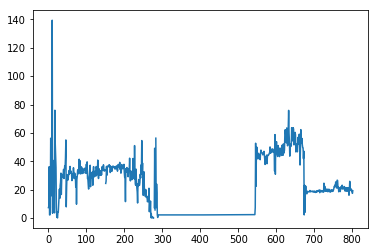

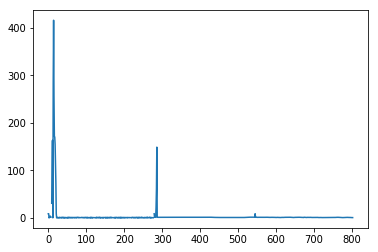

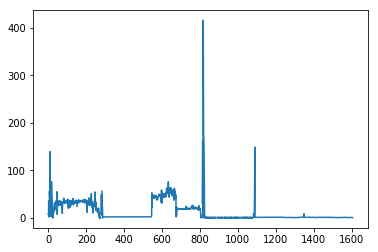

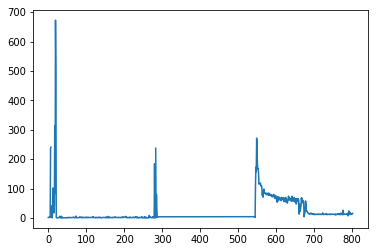

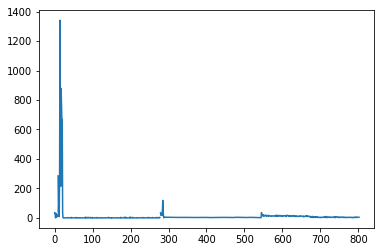

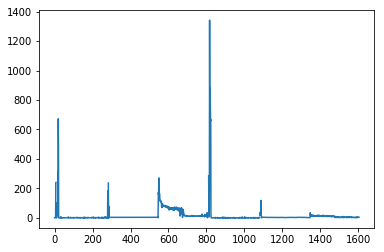

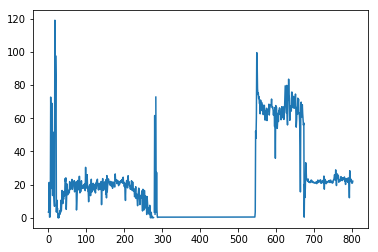

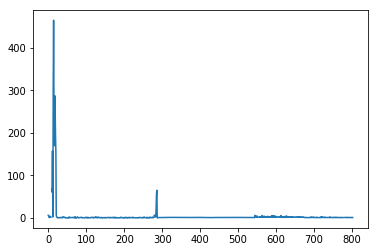

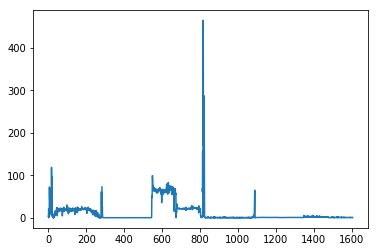

In [32]:
tmpmean = np.zeros((X.shape[0],len(tmpind))).tolist()
for i in range(X.shape[0]):
    for j in range(len(tmpind)):
        tmpmean[i][j] = np.zeros(best_fs_sc[i][j][0].shape)
        for k in range(best_fs_sc[i][j].shape[0]-1):
#             print best_fs_sc[i][j][k].shape
            tmpmean[i][j] += best_fs_sc[i][j][k]
#             print tmpmean[i][j].shape
        tmpmean[i][j] /= best_fs_sc[i][j].shape[0]
        plt.figure()
        plt.plot(tmpmean[i][j])
#         print tmpmean[i][j]

In [ ]:
# for clfid, clfval in enumerate(classifiers[:-1]):
#     grid_pip = make_pipe_clf(StandardScaler(),SelectKBest(),PCA(),clfval)


In [47]:
################################################## NORMALIZATION ###################################################
# normalize by abstracting mean and dividing by std
X = np.array([deepcopy(Xsp[i][-1]) for i in range(Xsp.shape[0])])
Y = deepcopy(Ysp)
print X.shape, Y.shape
tmpind = {}
tmpind[2] = range(X[0].shape[1])
tmpind[0] = range(X[0].shape[1]/2)
tmpind[1] = range(X[0].shape[1]/2,X[0].shape[1])
tmpind = np.array([i for _,i in tmpind.items()])
if os.path.isfile(XYnormfile):
    X = np.load(XYnormfile)['Xs']
    S = np.load(XYnormfile)['S']
    # X = np.load(XYfile)['Xn']
    # N = np.load(XYfile)['N']
else:
    Xn,S,N = {},{},{}
    for i in range(len(X)): # for all datasets
        S[i],N[i] = {},{}
        for j in range(len(tmpind)): # for all features
            S[i][j] = StandardScaler().fit(X[i][:,tmpind[j]])
            #N[i][j] = MinMaxScaler().fit(X[i][:,tmpind[j]])
        X[i] = S[i][len(tmpind)-1].transform(X[i])
        #Xn[i] = N[i][len(tmpind)-1].transform(X[i])
    S = np.array([[Sij for _,Sij in Si.items()] for _,Si in S.items()])
    #N = np.array([[Nij for _,Nij in Ni.items()] for _,Ni in N.items()])
    #Xn = np.array([i for _,i in Xn.items()])
    #np.savez(XYnormfile,Xs=X,Xn=Xn,S=S,N=N)
    np.savez(XYnormfile,Xs=X,S=S)
print 'normalized features: ', X[0].shape, X[1].shape, X[2].shape

(3,) (3,)
normalized features:  (7646, 1606) (8359, 1606) (7879, 1606)


In [49]:
########################################## Feature Names ###########################################################
####################################################################################################################
##  features:                                                                                  ||      if         ##
##  |----------> time domain      :                                                            || samples = 1024  ##
##  |------------|---> phinyomark : 11+3{shist} -----------------------------> = 14+0.0samples ||             14  ##
##  |------------|---> golz       : 10+samples{acrol} -----------------------> = 10+1.0samples ||           1034  ##
##  |----------> frequency domain :                                                                               ##
##  |------------|---> phinyomark : 3{arco}+4{mf}+2(samples/2+1){RF,IF} -----> =  9+1.0samples ||           1033  ##
##  |------------|---> golz       : 2(samples/2+1){AF,PF} ========-----------> =  2+1.0samples ||           1027  ##
##  |------------|--------|-------alltogether--------------------------------> = 35+3.0samples || numfeat = 3108  ##
####################################################################################################################
## Time Domain Phinyomark feats
featnames = ['intsgnl', 'meanabs', 'meanabsslp', 'ssi', 'var', 'rms', 'rng', 'wavl', 'zerox', 'ssc', 'wamp', 
             'shist1', 'shist2', 'shist3']                                                   # 11+3{shist}
## Frequency Domain Phinyomark feats
featnames += ['arco1', 'arco2', 'arco3', 'mnf', 'mdf', 'mmnf', 'mmdf']                       # 3{arco}+4{mf}
featnames += ['reFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{RF}
featnames += ['imFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{IF}
## Time Domain Golz feats
featnames += ['meanv', 'stdr', 'mx', 'rngx', 'rngy', 'med', 'hjorth', 'sentr', 'se', 'ssk']  # 10
featnames += ['acrol{:04d}'.format(i) for i in range(window)]                                # samples{acrol}
## Frequency Domain Golz feats
featnames += ['amFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{AF}
featnames += ['phFFT{:03d}'.format(i) for i in range(window/2+1)]                            # samples/2+1{PF}
# featnames += ['ffaf']                                                                        # 1{ffaf}

In [65]:
######################################## FEATURE SELECTION #########################################################
# feature names
# numfeat = 10 # number of features to show
# nfeat = 1000 # number of features to keep
#namesid = ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i) for i in range(X[0].shape[1])]
namesid = [['sf{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
           ['ftn{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
           ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i%X[0].shape[1]/2) for i in range(X[0].shape[1])]]
namesf = [['sf_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
         ['ftn_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
         ['sf_{}'.format(featnames[i]) if i<X[0].shape[1]/2 else 'ftn_{}'.format(featnames[i%X[0].shape[1]/2]) for i in range(X[0].shape[1])]]
########## use RandomizedLasso of MutualInfo as the model to select features and find their importances ############
featselfile = featpath+featname+'_featselall_subsample'+'.npz'
tmpind1 = {}
tmpind1[2] = range(X[2].shape[0])
tmpind1[0] = range(X[0].shape[0])
tmpind1[1] = range(X[1].shape[0])
tmpind1 = np.array([i for _,i in tmpind1.items()])
tmpskip = [int(len(tmpind1[i])/3000) for i in range(len(tmpind1))]
print tmpskip
#tmpskip = [1 for i in range(3)]
start_time = time.time()
if os.path.isfile(featselfile):
    #rlasso = np.load(featselfile)['rlasso'].tolist()
    featsel = np.load(featselfile)['featsel'].tolist()
    print("Selected Features FOUND PRECOMPUTED! Loading DONE in: %s seconds " % (time.time() - start_time))
else:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', ConvergenceWarning)
        # loop for all datasets (12,3,all) and all features (sf,ftn,all)
        #featsel = [[RandomizedLasso(fit_intercept=False,normalize=False).fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
        #Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])
        featsel = [Parallel(n_jobs=-1)([delayed(SelectKBest(mutual_info_classif,'all').fit) 
                    (X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]])
                    for i,j in itertools.product(range(len(X)),range(3))])]
        featsel = np.array([[featsel[0][i*len(range(3))+j] for j in range(3)] for i in range(len(X))])
                   #for j in range(3) for i in range(len(X))]
#         featsel = [[SelectKBest(mutual_info_classif,'all').fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
#                     for j in range(3)] for i in range(len(X))]
        print("Selected Features NOT FOUND PRECOMPUTED! Selection DONE in: %s seconds " % (time.time() - start_time))
        #np.savez(featselfile,rlasso=np.array(rlasso))
        np.savez(featselfile,featsel=featsel)
# rank features
print "----> Features sorted by their rank (std norm):"
bestix = {}
wrstix = {}
for i in range(len(X)): # for all diff data sets
    bestix[i] = {}
    wrstix[i] = {}
    for j in range(3): # for all diff feature sets
        tmp = sorted(zip(map(lambda x: round(x,4), featsel[i][j].scores_),namesf[j]),reverse=True)
        bestix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::-1]
        #wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:nfeat][::1]
        wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::1]
        print 'Best '+str(numfeat)+': ',tmp[:numfeat], bestix[i][j].shape, bestix[i][j][:numfeat]
        print 'Worst '+str(numfeat)+': ',tmp[-numfeat:], wrstix[i][j].shape, wrstix[i][j][:numfeat]
bestix = np.array([[ij for _,ij in i.items()] for _,i in bestix.items()])
wrstix = np.array([[ij for _,ij in i.items()] for _,i in wrstix.items()])
# print "----> Features sorted by their rank (minmax norm):"
# print sorted(zip(map(lambda x: round(x,4), rlasso2.scores_),names),reverse=True)[:numfeat]

[2, 2, 2]
Selected Features FOUND PRECOMPUTED! Loading DONE in: 0.00191497802734 seconds 
----> Features sorted by their rank (std norm):
Best 10:  [(0.3708, 'sf_mx'), (0.3169, 'sf_med'), (0.2955, 'sf_acrol0191'), (0.2923, 'sf_acrol0190'), (0.2921, 'sf_acrol0153'), (0.2917, 'sf_acrol0227'), (0.2915, 'sf_acrol0192'), (0.291, 'sf_acrol0237'), (0.2909, 'sf_acrol0156'), (0.2908, 'sf_acrol0224')] (803,) [281 284 480 479 442 516 481 526 445 513]
Worst 10:  [(0.0331, 'sf_amFFT099'), (0.0331, 'sf_amFFT087'), (0.0329, 'sf_phFFT099'), (0.0329, 'sf_phFFT087'), (0.0318, 'sf_shist1'), (0.0089, 'sf_imFFT000'), (0.0074, 'sf_ssc'), (0.0012, 'sf_imFFT128'), (0.001, 'sf_rngx'), (0.0, 'sf_zerox')] (803,) [  8 282 278   9 150  11 761 773 644 632]
Best 10:  [(0.5494, 'ftn_mx'), (0.5435, 'ftn_rngy'), (0.5435, 'ftn_rng'), (0.5155, 'ftn_med'), (0.4929, 'ftn_acrol0204'), (0.4929, 'ftn_acrol0191'), (0.4927, 'ftn_acrol0158'), (0.4918, 'ftn_acrol0171'), (0.4917, 'ftn_acrol0172'), (0.4916, 'ftn_acrol0232')] (803,)

In [66]:
# ######################################## FEATURE SELECTION #########################################################
# # feature names
# # numfeat = 10 # number of features to show
# # nfeat = 1000 # number of features to keep
# #namesid = ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i) for i in range(X[0].shape[1])]
# namesid = [['sf{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
#            ['ftn{:04d}'.format(i) for i in range(X[0].shape[1]/2)],
#            ['sf{:04d}'.format(i) if i<X[0].shape[1]/2 else 'ftn{:04d}'.format(i%X[0].shape[1]/2) for i in range(X[0].shape[1])]]
# namesf = [['sf_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
#          ['ftn_{}'.format(featnames[i]) for i in range(X[0].shape[1]/2)],
#          ['sf_{}'.format(featnames[i]) if i<X[0].shape[1]/2 else 'ftn_{}'.format(featnames[i%X[0].shape[1]/2]) for i in range(X[0].shape[1])]]
# ########## use RandomizedLasso of MutualInfo as the model to select features and find their importances ############
# featselfile = featpath+featname+'_featselall_new'+'.npz'
# tmpind1 = {}
# tmpind1[2] = range(X[2].shape[0])
# tmpind1[0] = range(X[0].shape[0])
# tmpind1[1] = range(X[1].shape[0])
# tmpind1 = np.array([i for _,i in tmpind1.items()])
# tmpskip = [int(len(tmpind1[i])/3000) for i in range(len(tmpind1))]
# print tmpskip
# #tmpskip = [1 for i in range(3)]
# start_time = time.time()
# if os.path.isfile(featselfile):
#     #rlasso = np.load(featselfile)['rlasso'].tolist()
#     featsel = np.load(featselfile)['featsel'].tolist()
#     print("Selected Features FOUND PRECOMPUTED! Loading DONE in: %s seconds " % (time.time() - start_time))
# else:
#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', UserWarning)
#         warnings.simplefilter('ignore', ConvergenceWarning)
#         # loop for all datasets (12,3,all) and all features (sf,ftn,all)
#         #featsel = [[RandomizedLasso(fit_intercept=False,normalize=False).fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
#         #Parallel(n_jobs=-1)([delayed(feat) (p[k:k+window],*featparam) for k in range(0,len(p)-window,shift)])
#         featsel = [Parallel(n_jobs=-1)([delayed(SelectKBest(f_classif,'all').fit) 
#                     (X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]])
#                     for i,j in itertools.product(range(len(X)),range(3))])]
#         featsel = np.array([[featsel[0][i*len(range(3))+j] for j in range(3)] for i in range(len(X))])
#                    #for j in range(3) for i in range(len(X))]
# #         featsel = [[SelectKBest(mutual_info_classif,'all').fit(X[i][:-1:tmpskip[i],tmpind[j]],Y[i][:-1:tmpskip[i]]) 
# #                     for j in range(3)] for i in range(len(X))]
#         print("Selected Features NOT FOUND PRECOMPUTED! Selection DONE in: %s seconds " % (time.time() - start_time))
#         #np.savez(featselfile,rlasso=np.array(rlasso))
#         np.savez(featselfile,featsel=featsel)
# # rank features
# print "----> Features sorted by their rank (std norm):"
# bestix = {}
# wrstix = {}
# for i in range(len(X)): # for all diff data sets
#     bestix[i] = {}
#     wrstix[i] = {}
#     for j in range(3): # for all diff feature sets
#         tmp = sorted(zip(map(lambda x: round(x,4), featsel[i][j].scores_),namesf[j]),reverse=True)
#         bestix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::-1]
#         #wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:nfeat][::1]
#         wrstix[i][j] = np.array(featsel[i][j].scores_).argsort()[:][::1]
#         print 'Best '+str(numfeat)+': ',tmp[:numfeat], bestix[i][j].shape, bestix[i][j][:numfeat]
#         print 'Worst '+str(numfeat)+': ',tmp[-numfeat:], wrstix[i][j].shape, wrstix[i][j][:numfeat]
# bestix = np.array([[ij for _,ij in i.items()] for _,i in bestix.items()])
# wrstix = np.array([[ij for _,ij in i.items()] for _,i in wrstix.items()])
# # print "----> Features sorted by their rank (minmax norm):"
# # print sorted(zip(map(lambda x: round(x,4), rlasso2.scores_),names),reverse=True)[:numfeat]

In [67]:
################################ BEST and WORST FEATURES for each dataset and feature pair #########################
for i in range(len(X)): # for all diff data sets
    for j in range(3): # for all diff feature sets
        tmpfsz = np.array(namesf[j]).shape[0]
        print np.array([namesf[j][bestix[i][j][k]] for k in range(tmpfsz)]).shape
        tmpb = list(OrderedDict.fromkeys([re.sub('[^a-zA-Z]','',namesf[j][bestix[i][j][k]]) for k in range(tmpfsz)]))
        #tmpb = list(OrderedDict.fromkeys([filter(str.isdigit,namesf[j][bestix[i][j][k]]) for k in range(tmpfsz)]))
        tmpw = list(OrderedDict.fromkeys([filter(str.isalpha,namesf[j][wrstix[i][j][k]]) for k in range(tmpfsz)]))
        print '----------------------------------------------------------------------------------------------------'
        print 'Features for ',i,j,' sorted: ',tmpb,np.array(tmpb).shape
        print 'Features for ',i,j,' sorted: ',tmpw[::-1],np.array(tmpw).shape,tmpfsz

(803,)
----------------------------------------------------------------------------------------------------
Features for  0 0  sorted:  ['sfmx', 'sfmed', 'sfacrol', 'sfse', 'sfvar', 'sfssi', 'sfrms', 'sfintsgnl', 'sfamFFT', 'sfmeanabs', 'sfreFFT', 'sfmeanv', 'sfphFFT', 'sfrng', 'sfrngy', 'sfmeanabsslp', 'sfimFFT', 'sfwavl', 'sfarco', 'sfstdr', 'sfwamp', 'sfmnf', 'sfmmnf', 'sfmmdf', 'sfssk', 'sfhjorth', 'sfshist', 'sfsentr', 'sfmdf', 'sfssc', 'sfrngx', 'sfzerox'] (32,)
Features for  0 0  sorted:  ['sfmx', 'sfmed', 'sfse', 'sfvar', 'sfssi', 'sfrms', 'sfintsgnl', 'sfmeanabs', 'sfmeanv', 'sfacrol', 'sfrng', 'sfrngy', 'sfmeanabsslp', 'sfwavl', 'sfstdr', 'sfwamp', 'sfmnf', 'sfmmnf', 'sfmmdf', 'sfarco', 'sfssk', 'sfhjorth', 'sfreFFT', 'sfsentr', 'sfmdf', 'sfamFFT', 'sfphFFT', 'sfshist', 'sfssc', 'sfimFFT', 'sfrngx', 'sfzerox'] (32,) 803
(803,)
----------------------------------------------------------------------------------------------------
Features for  0 1  sorted:  ['ftnmx', 'ftnrng', 'f

In [68]:
# ############################### DIMENSIONALITY REDUCTION VIA FEATURE SELECTION #####################################
# fig = plt.figure(figsize=(8,6))
# r,c = np.array(featsel).shape[0],np.array(featsel).shape[1]
# Xfs = {}
# matplotlib.rcParams['text.usetex'] = True
# for i in range(r):
#     Xfs[i] = {}
#     for j in range(c):
#         Xfs[i][j] = np.array(featsel[i][j].transform(X[i][:,tmpind[j]]))[:,bestix[i][j][:nfeat]]
#         print Xfs[i][j].shape
#         ax = fig.add_subplot(r,c,i*c+j+1)
#         ax.plot(featsel[i][j].scores_,'b')
#         ax.scatter(bestix[i][j][:nfeat],featsel[i][j].scores_[bestix[i][j][:nfeat]],color='r')
#         if i==0 and j==0:
#             ax.set_title(r'$\zeta_1=\sigma(|f|)$')
#             ax.set_ylabel(r'$d_1$')
#         if i==0 and j==1:
#             ax.set_title(r'$\zeta_2=\sigma(|f_t/f_n|)$')
#         if i==0 and j==2:
#             ax.set_title(r'$\zeta_3=\zeta_1\bigcup \zeta_2$')
#         if i==1 and j==0:
#             ax.set_ylabel(r'$d_2$')
#         if i==2 and j==0:
#             ax.set_ylabel(r'$d_3=d_1\bigcup d_2$')
#         if i==2:
#             ax.set_xlabel('features')
# Xfs = np.array([[i for _,i in Xfsi.items()] for _,Xfsi in Xfs.items()])
# #plt.show()
# savefig('plots/'+featname+'_featsel.png', bbox_inches='tight')
# savefig('plots/featureselection.eps',format='eps',dpi=50,bbox_inches='tight')

(7646, 750)
(7646, 750)
(7646, 750)
(8359, 750)
(8359, 750)
(8359, 750)
(7879, 750)
(7879, 750)
(7879, 750)


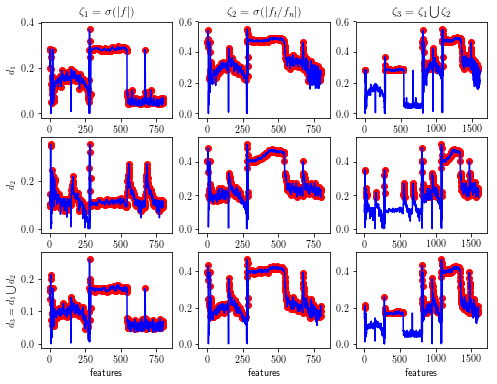

In [69]:
############################### DIMENSIONALITY REDUCTION VIA FEATURE SELECTION #####################################
fig = plt.figure(figsize=(8,6))
r,c = np.array(featsel).shape[0],np.array(featsel).shape[1]
Xfs = {}
matplotlib.rcParams['text.usetex'] = True
for i in range(r):
    Xfs[i] = {}
    for j in range(c):
        Xfs[i][j] = np.array(featsel[i][j].transform(X[i][:,tmpind[j]]))[:,bestix[i][j][:nfeat]]
        print Xfs[i][j].shape
        ax = fig.add_subplot(r,c,i*c+j+1)
        ax.plot(featsel[i][j].scores_,'b')
        ax.scatter(bestix[i][j][:nfeat],featsel[i][j].scores_[bestix[i][j][:nfeat]],color='r')
        if i==0 and j==0:
            ax.set_title(r'$\zeta_1=\sigma(|f|)$')
            ax.set_ylabel(r'$d_1$')
        if i==0 and j==1:
            ax.set_title(r'$\zeta_2=\sigma(|f_t/f_n|)$')
        if i==0 and j==2:
            ax.set_title(r'$\zeta_3=\zeta_1\bigcup \zeta_2$')
        if i==1 and j==0:
            ax.set_ylabel(r'$d_2$')
        if i==2 and j==0:
            ax.set_ylabel(r'$d_3=d_1\bigcup d_2$')
        if i==2:
            ax.set_xlabel('features')
Xfs = np.array([[i for _,i in Xfsi.items()] for _,Xfsi in Xfs.items()])
#plt.show()
savefig('plots/'+featname+'_featsel.png', bbox_inches='tight')
savefig('plots/featureselection.eps',format='eps',dpi=50,bbox_inches='tight')

(765, 20) (765,) [ 0.54196212  0.32106689  0.08641181  0.01384505  0.00459279  0.00312459
  0.00228007  0.00212307  0.0019488   0.00176132  0.00162253  0.00139886
  0.00130863  0.00121979  0.0010881   0.00102104  0.00093012  0.00086418
  0.000798    0.00076344]
(765, 20) (765,) [  7.25945242e-01   2.67555131e-01   3.18016625e-03   1.07584307e-03
   8.54351420e-04   5.47246672e-04   3.38768114e-04   2.61767067e-04
   1.00982107e-04   7.18383399e-05   3.04297946e-05   1.56853927e-05
   1.25607128e-05   4.98563721e-06   1.41206994e-06   1.02969858e-06
   6.73524494e-07   4.01487588e-07   2.10796551e-07   1.63983858e-07]
(765, 20) (765,) [  6.36933345e-01   2.07580977e-01   1.52434332e-01   1.18809579e-03
   6.94235922e-04   4.55945959e-04   3.40650113e-04   2.21432886e-04
   6.97972117e-05   2.98784422e-05   2.20300049e-05   1.44540635e-05
   5.47645764e-06   3.24764487e-06   1.41314460e-06   1.29655807e-06
   9.38800619e-07   4.82916278e-07   3.43853907e-07   3.01063264e-07]
(836, 20) (8

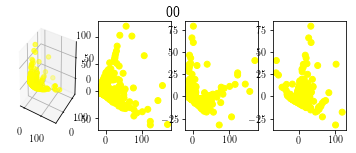

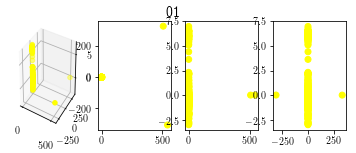

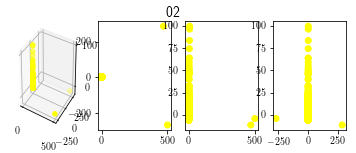

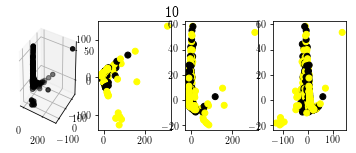

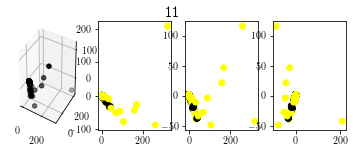

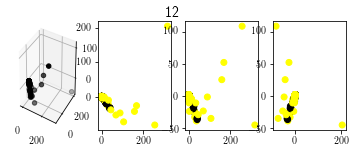

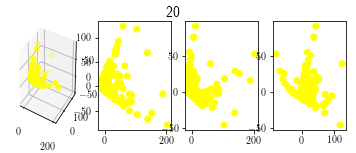

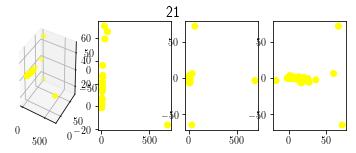

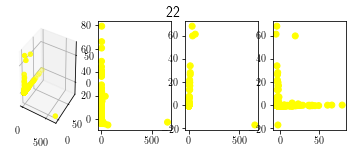

In [70]:
################################### DIMENSIONALITY REDUCTION PCA ##################################################
featdimredfile = featpath+featname+'_dimred'+'.npz'
ncomp = 20
tmpskip = 10
if os.path.isfile(featdimredfile):
    inpdimred = np.load(featdimredfile)
    pca = inpdimred['pca'].tolist()
    Xpca = inpdimred['Xpca']
    tmpix = inpdimred['tmpix']
else:
    # PCA
    r,c = Xfs.shape[0],Xfs.shape[1]
    Xpca,pca,tmpix = {},{},{}
    for i in range(r):
        Xpca[i],pca[i] = {},{}
        tmpix[i] = range(0,Xfs[i][0].shape[0],tmpskip)
        for j in range(c):
            pca[i][j] = PCA(n_components=ncomp, random_state=0)
            pca[i][j].fit(Xfs[i][j][tmpix[i],:])
            Xpca[i][j] = pca[i][j].transform(Xfs[i][j][tmpix[i],:])
    pca = np.array([[i for _,i in pcai.items()] for _,pcai in pca.items()])
    Xpca = np.array([[i for _,i in Xpcai.items()] for _,Xpcai in Xpca.items()])
    tmpix = np.array([i for _,i  in tmpix.items()])
    np.savez(featdimredfile,pca=pca,Xpca=Xpca,tmpix=tmpix)
for i in range(r):
    for j in range(c):
        print Xpca[i][j].shape, np.array(tmpix[i]).shape ,(pca[i][j].explained_variance_ratio_)
        ################################## VISUALIZATION OF DIMENSIONALITY REDUCTION ###############################
        fig = plt.figure(figsize=(6,2))
        fig.suptitle(str(i)+str(j), fontsize=14, fontweight='bold')
        #ax = Axes3D(fig)
        #fig = plt.figure()
        #ax = fig.add_subplot(111, projection='3d')
        ax = fig.add_subplot(141, projection='3d')
        #ax = fig.add_subplot(141)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,1],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(142)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,1],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(143)
        ax.scatter(Xpca[i][j][:,0],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))
        ax = fig.add_subplot(144)
        ax.scatter(Xpca[i][j][:,1],Xpca[i][j][:,2],c=Y[i][:,np.newaxis]*np.array([[1,1,0]]))

(9, 2)
Dataset size and plots of 2 first X1 cols and Y1
(765, 20) (765,)
(836, 20) (836,)
(788, 20) (788,)
(765, 20) (765,)
(836, 20) (836,)
(788, 20) (788,)
(765, 20) (765,)
(836, 20) (836,)
(788, 20) (788,)


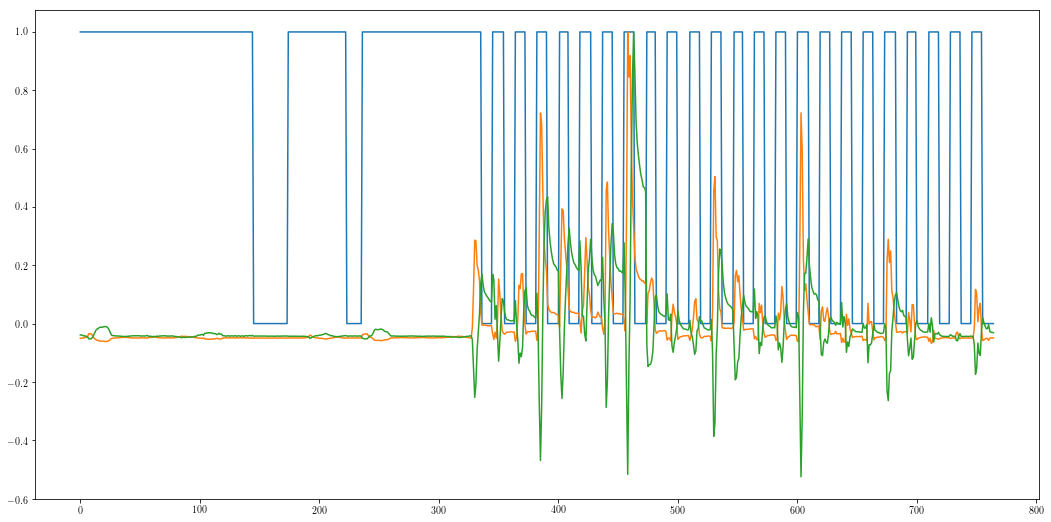

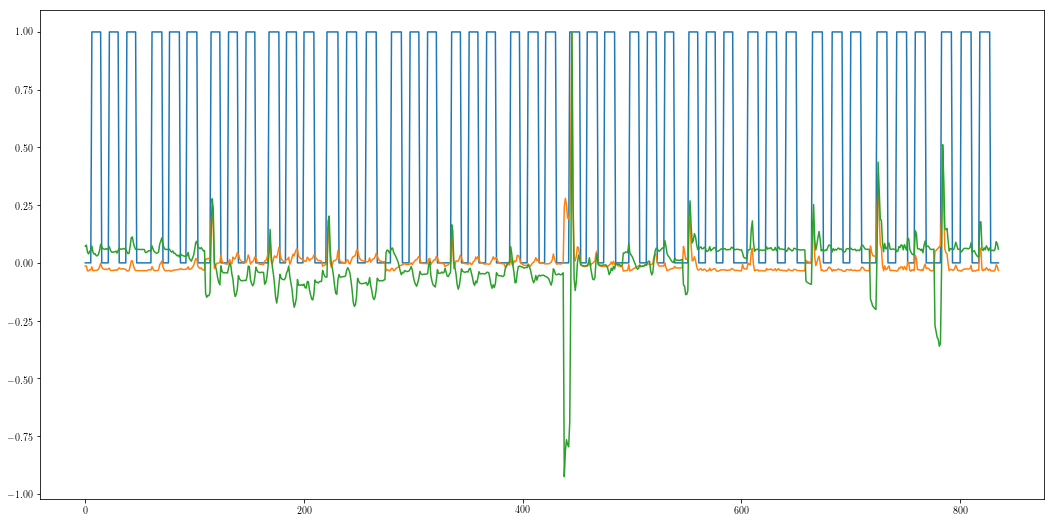

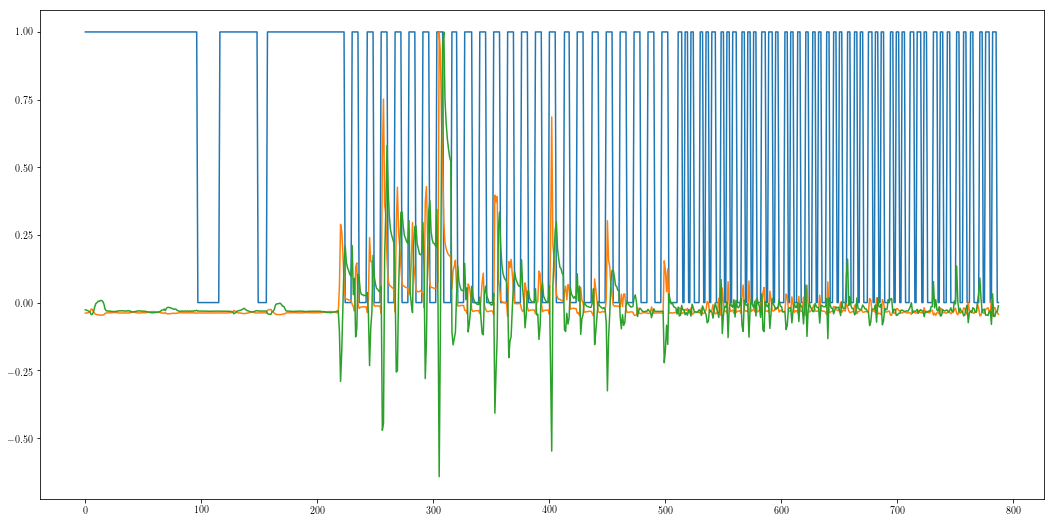

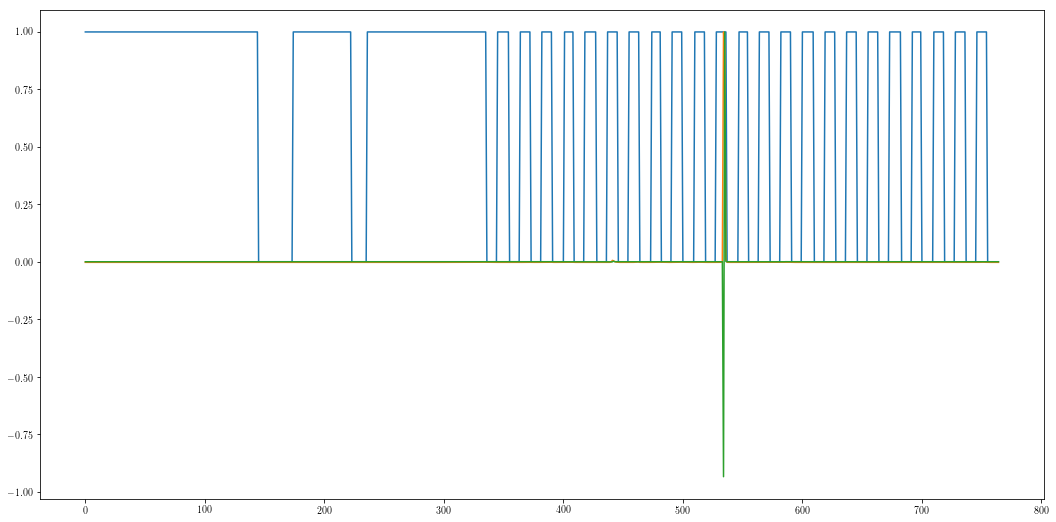

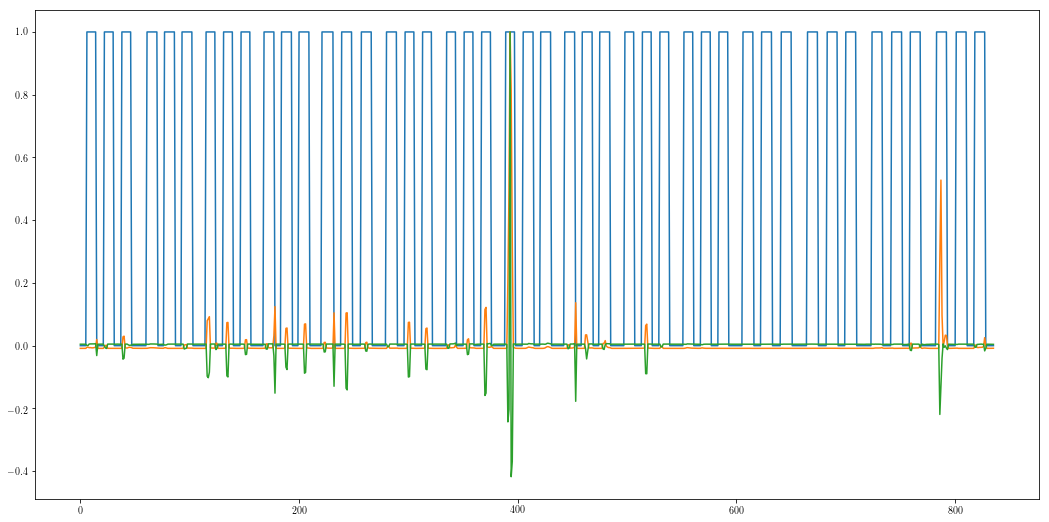

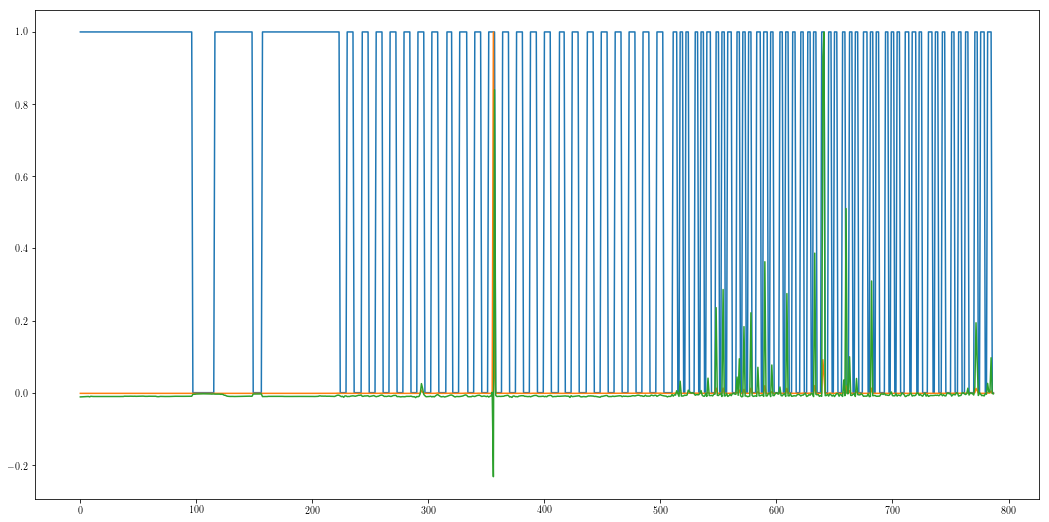

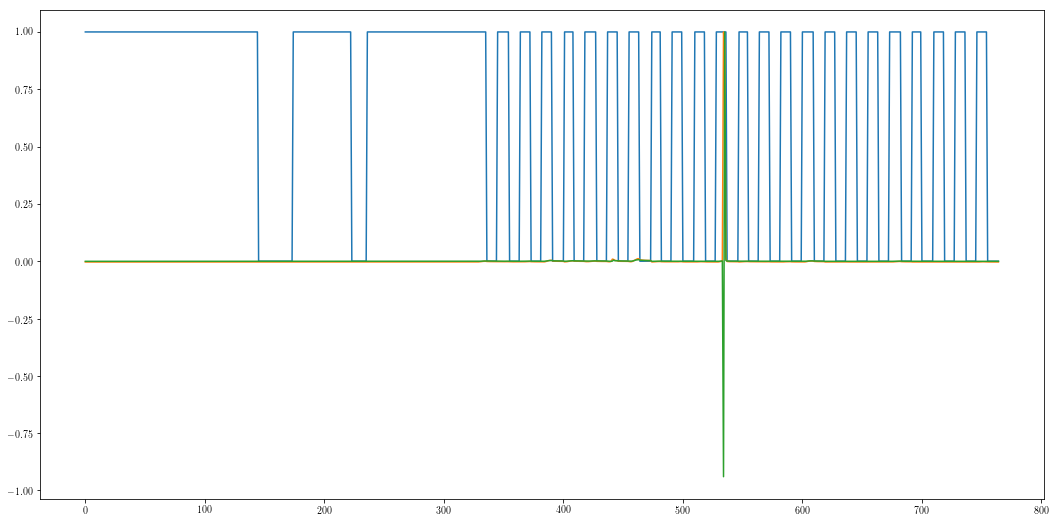

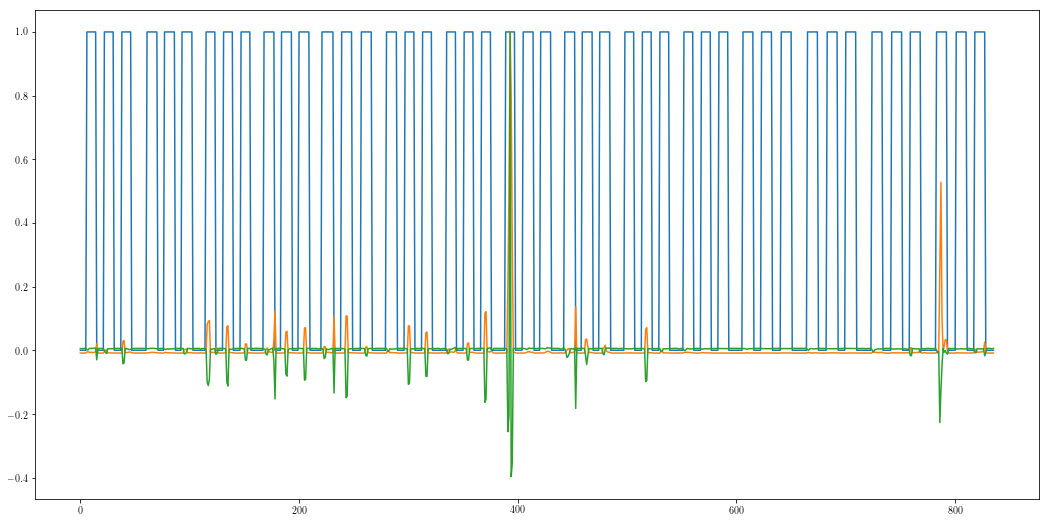

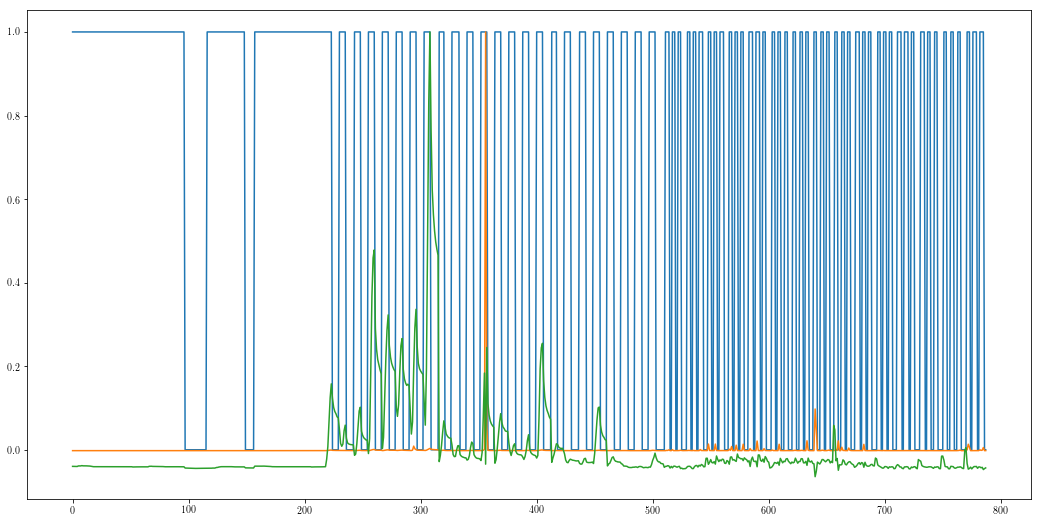

In [71]:
######################################## DATASETS PREPARATION ######################################################
datasets = [(Xpca[i][j],Y[i][tmpix[i]]) for j in range(c) for i in range(r)]
print np.array(datasets).shape
print "Dataset size and plots of 2 first X1 cols and Y1"
for ds in datasets:
    X1,Y1 = ds
    print X1.shape,Y1.shape
    plt.figure(figsize=(18,9))
    plt.plot(Y1)
    plt.hold
#     plt.plot(X1[:,:2])
    plt.plot(X1[:,:2]/np.max(X1[:,:2],axis=0))

In [72]:
# grid = [gs_fun(clf,parameters[clf_ind], cv, X,Y) for (clf_ind,clf) in enumerate(classifiers) for X,Y in datasets]

xmin,xmax,ymin,ymax:  -12.0778410827 171.467782362 -63.0695368968 119.663481611
Fitting... 
NearNb
1 0.90522875817 0.90522875817 0.895656619073 0.0327666617564 0.91506257712 0.0277055523166 --secs: 2.09808349609e-05
Fitting... 
RBFSVM1
2 0.826797385621 0.915032679739 0.846576767143 0.0295501227855 0.911838533404 0.024292825861 --secs: 2.59876251221e-05
Fitting... 
MLP1
3 0.882352941176 0.918300653595 0.863183500793 0.0541073638161 0.908556319408 0.0217337316711 --secs: 1.81198120117e-05
Fitting... 
RandFor
4 0.875816993464 0.892156862745 0.87264762912 0.0181541533546 0.889099242024 0.0518921861216 --secs: 2.50339508057e-05
EnsembleMLP
Fitting... 
5 0.872549019608 0.921568627451 0.915115459193 0.0115460000024 0.947639696809 0.0162126527483 --secs: 0.000198125839233
xmin,xmax,ymin,ymax:  -11.8448019289 310.990077375 -127.162199199 137.279851562
Fitting... 
NearNb
6 0.692537313433 0.8 0.746422965387 0.0432038307454 0.823949769867 0.0533389962608 --secs: 2.21729278564e-05
Fitting... 
RBFSV

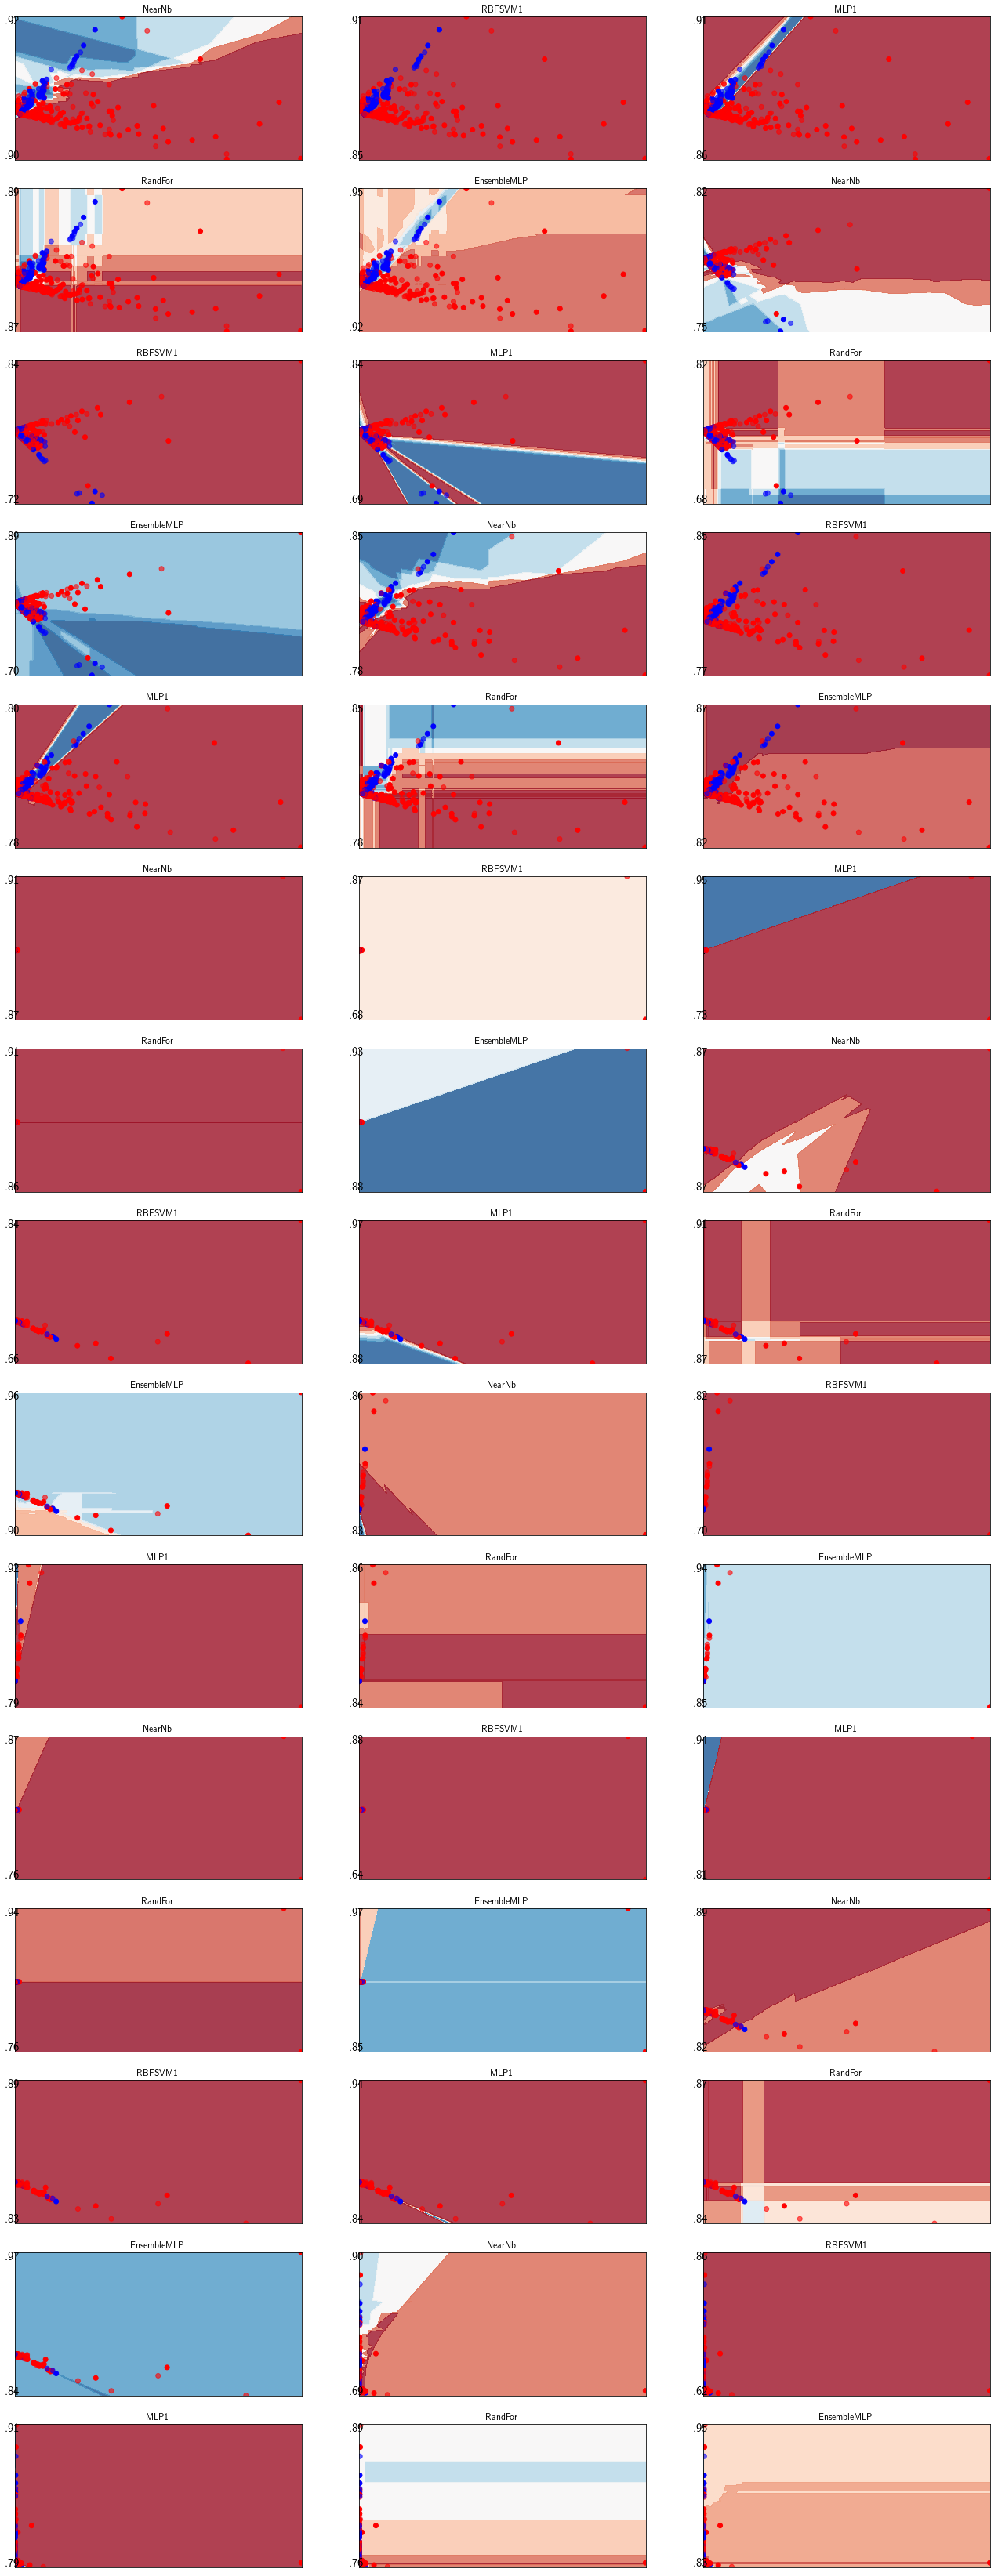

In [79]:
######################################### TRAINING OF ML CLASSIFIERS ###############################################
figure = plt.figure(figsize=(18, 72))
i = 1

#clffile = datapath+'trained_classifiers_'+str(window)+'_'+str(shift)+'.npz'
clffile = clfmodelfile
if os.path.isfile(clffile):
    clfall = np.load(clffile)['clfall']
    clfpall = np.load(clffile)['clfpall']
else:
    clfall = []
    clfpall = []
# iterate over datasets
start_time = time.time()
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    ncomp = 2
    # Keep the first ncomp of pca of X to visualize the results
    Xp = X[:,:ncomp]

    X_train, X_test, y_train, y_test, Xp_train, Xp_test = train_test_split(X, y, Xp, test_size=.4)
    
    x_min, x_max = Xp[:, 0].min() - .5, Xp[:, 0].max() + .5
    y_min, y_max = Xp[:, 1].min() - .5, Xp[:, 1].max() + .5
    print "xmin,xmax,ymin,ymax: ",x_min, x_max, y_min, y_max
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # just pick the colors used to represent the labels first
    cm = plt.cm.RdBu_r
    cm_bright = ListedColormap(['#0000FF', '#FF0000']) # blue:0 (stable), red: 1 (slip)
    
    clfmodels = []
    clfpmodels = []
    pred = []
    predp = []
    predts = []
    predpts = []
    score = []
    scorep = []
    scorec = []
    scorepc = []
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        tmpix = (i-1)%len(classifiers)
        ax = plt.subplot(len(datasets)*2, ceil(len(classifiers)/2.), i)
        if os.path.isfile(clffile):
            clfp = clfpall[i-1]
        else:
            clfp = deepcopy(clf)
        if i%(len(names))!=0:
            if not os.path.isfile(clffile):
                print "Fitting... "
                clf.fit(X_train, y_train)
                clfp.fit(Xp_train,y_train)
#             if i%(len(names)) == 8: # LASSOCV
            print names[(i-1)%len(names)]
            if names[(i-1)%(len(names))] == "Lasso":
                if not os.path.isfile(clffile):
                    print 
                    model = SelectFromModel(clf, prefit=True)
                else:
                    model = SelectFromModel(clfall[i-1], prefit=True)
                X_new = model.transform(X_train)
                print X_train.shape, X_new.shape
        else: # if classifier is ensemble mlp
            print names[(i-1)%len(names)]
            newX_train = np.array(pred).transpose()
            newXp_train = np.array(predp).transpose()
            if not os.path.isfile(clffile):
                print "Fitting... "
                clf.fit(newX_train,y_train)
                clfp.fit(newXp_train,y_train)
        if not os.path.isfile(clffile):
            clfmodels += [clf]
        else:
            clfmodels += [clfall[i-1]]
        clfpmodels += [clfp]
        if i%(len(names))!=0:
            if not os.path.isfile(clffile):
                npred = clf.predict(X_test)
            else:
                npred = clfall[i-1].predict(X_test)
            npredp = clfp.predict(Xp_test)
            t1 = time.time()
            score += [sum(((npred>0.5).astype(int)==y_test).astype(int))*1./len(y_test)]
            t2 = (time.time()-t1)
            scorep += [sum(((npredp>0.5).astype(int)==y_test).astype(int))*1./len(y_test)]
            try:
                if not os.path.isfile(clffile):
                    scorec += [cross_val_score(clf,X_test,y_test,cv=CV,scoring=metr)]
                else:
                    scorec += [cross_val_score(clfall[i-1],X_test,y_test,cv=CV,scoring=metr)]
                scorepc += [cross_val_score(clfp,Xp_test,y_test,cv=CV,scoring=metr)]
            except ValueError:
                scorec += [np.array(score[tmpix])]
                scorepc += [np.array([scorep[tmpix]])]      
            if not os.path.isfile(clffile):
                if hasattr(clf, "predict_proba"):
                    pred += [clf.predict_proba(X_train)[:,1]]
                    predts += [clf.predict_proba(X_test)[:,1]]
                else:
                    pred += [clf.predict(X_train)]
                    predts += [clf.predict(X_test)]
            else:
                if hasattr(clf, "predict_proba"):
                    pred += [clfall[i-1].predict_proba(X_train)[:,1]]
                    predts += [clfall[i-1].predict_proba(X_test)[:,1]]
                else:
                    pred += [clfall[i-1].predict(X_train)]
                    predts += [clfall[i-1].predict(X_test)]
            if hasattr(clfp, "predict_proba"):
                predp += [clfp.predict_proba(Xp_train)[:,1]]
                predpts += [clfp.predict_proba(Xp_test)[:,1]]
            else:
                predp += [clfp.predict(Xp_train)]
                predpts += [clfp.predict(Xp_test)]
        else: # if classifier is ensemble MLP
            newX_test = np.array(predts).transpose()
            newXp_test = np.array(predpts).transpose()
            t1 = time.time()
            if not os.path.isfile(clffile):
                score += [clf.score(newX_test, y_test)]
            else:
                score += [clfall[i-1].score(newX_test, y_test)]
            t2 = (time.time()-t1)#*1./len(y_test)
            scorep += [clfp.score(newXp_test, y_test)]
            try:
                if not os.path.isfile(clffile):
                    scorec += [cross_val_score(clf,newX_test,y_test,cv=CV,scoring=metr)]
                else:
                    scorec += [cross_val_score(clfall[i-1],newX_test,y_test,cv=CV,scoring=metr)]
                scorepc += [cross_val_score(clfp,newXp_test,y_test,cv=CV,scoring=metr)]
            except ValueError:
                scorec += [np.array(score[tmpix])]
                scorepc += [np.array([scorep[tmpix]])]
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]*[y_min, y_max].
        Zlist = []
        if i%(len(names))!=0:
            if not hasattr(clfp, "predict_proba"):
                Z = clfp.predict(np.c_[xx.ravel(), yy.ravel()])
            else:
                try:
                    Z = clfp.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                except MemoryError:
                    print "Memory Error Handled!"
                    Z = clfp.predict(np.c_[xx.ravel(), yy.ravel()])
            Zlist += [Z]
        else: # if classifier is ensemble MLP
            Z = np.zeros((np.c_[xx.ravel(), yy.ravel()].shape[0]))
            j = 0
            for clfpi in clfpmodels:
                if j >= len(clfmodels)-1:
                    continue
                mult = (clfp.intercepts_[0][:,np.newaxis]*clfp.intercepts_[1]*clfp.intercepts_[2])[:,0]
                if not hasattr(clfpi, "predict_proba"):
                    #Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
                    #Z += clf.intercepts_[0][j]*clfpi.decision_function(np.c_[xx.ravel(), yy.ravel()])
                    #Z += clf.intercepts_[0][j]*clfpi.predict(np.c_[xx.ravel(), yy.ravel()])
                    Z += mult[j]*clfpi.predict(np.c_[xx.ravel(), yy.ravel()])
                else:
                    #Z += clf.intercepts_[0][j]*clfpi.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                    Z += mult[j]*clfpi.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                j += 1
                Zlist += [Z]
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(Xp_train[:, 0], Xp_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(Xp_test[:, 0], Xp_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.min()+0.02*(xx.max()-xx.min()), yy.max()-0.05*(yy.max()-yy.min()), ('%.2f' % scorec[tmpix].mean()).lstrip('0'),
                size=15, horizontalalignment='right')
        ax.text(xx.min()+0.02*(xx.max()-xx.min()), yy.min()+0.01*(yy.max()-yy.min()), ('%.2f' % scorepc[tmpix].mean()).lstrip('0'),
                size=15, horizontalalignment='right')
        print i, scorep[tmpix], score[tmpix], scorepc[tmpix].mean(), scorepc[tmpix].std(),\
               scorec[tmpix].mean(), scorec[tmpix].std() , '--secs:', t2
        i += 1
    if not os.path.isfile(clffile):
        clfall += deepcopy(clfmodels)
        clfpall += deepcopy(clfpmodels)
figure.subplots_adjust(left=.02, right=.98)
print("--- %s seconds ---" % (time.time() - start_time))
#plt.show()
savefig('plots/'+featname+'.png', bbox_inches='tight')

In [80]:
########################################## Saving/Loading ML Models ################################################
if not os.path.isfile(clffile):
    np.savez(clffile,clfall=np.array(clfall),clfpall=np.array(clfpall))
else:
    clfall = np.load(clffile)['clfall']
print np.array(clfall).shape

(45,)


In [82]:
################################# Saving STD, FEATSEL, PCA, ML Models for online usage #############################
# modelfile = datapath+'allmodels_trans_gs'+str(window)+'_'+str(shift)+'.npz'
if not os.path.isfile(modelfile):
    np.savez(modelfile,clfall=np.array(clfall),bestsel=bestix,stdtran=S,pca=pca)
else:
    clfall = np.load(modelfile)['clfall']
    bestsel = np.load(modelfile)['bestsel']
    stdtran = np.load(modelfile)['stdtran']
    pca = np.load(modelfile)['pca']
    print np.array(clfall).shape, bestsel.shape, stdtran.shape, pca.shape

(45,) (3, 3) (3, 3) (3, 3)


In [90]:
################################### Computing test inputs for validation ###########################################
ix = [[0,3,6],[1,4,7],[2,5,8]]
dsfile = featpath+featname+'_testds'+'.npz'
S = stdtran
bestix = bestsel
if os.path.isfile(dsfile):
    ds = np.load(dsfile)['ds']
else:
    ds = {}
#     X = np.load(XYfile)['X']
#     Y = np.load(XYfile)['Y']
    X = np.load(XYsplitfile)['Xsp']
    Y = np.load(XYsplitfile)['Ysp']
    r = X.shape[0]
    c = 3
#     tmpind = {}
#     tmpind[2] = range(X[0].shape[1])
#     tmpind[0] = range(X[0].shape[1]/2)
#     tmpind[1] = range(X[0].shape[1]/2,X[0].shape[1])
#     tmpind = np.array([i for _,i in tmpind.items()])
    rng = np.random.RandomState(2)
    X += 0.0 * rng.uniform(size=X.shape)
    for i in range(r): # for all datasets (take each scaler and pca)
        ds[i] = {} 
        for j in range(r): # for all datasets as well (transform all of them with the given scaler and pca)
            ds[i][j] = {}
            for k in range(c): # for all feature dimensions
#                 tmpnorm = S[i][k].transform(X[j][:,tmpind[k]])
                tmpnorm = S[i][k].transform(X[j][k])
                #Xfs[i][k] = np.array(featsel[i][k].transform(tmpnorm))[:,bestix[i][k][:nfeat]]
                tmpfs = np.array(tmpnorm)[:,bestix[i][k][:nfeat]]
                ds[i][j][k] = pca[i][k].transform(tmpfs) # transform with pca(i,k) all Xfs(j,k) 
#                 print i,j,k,tmpfs.shape,ds[i][j][k].shape,Y[j].shape,X[j][:,tmpind[k]].shape,tmpnorm.shape
                print i,j,k,tmpfs.shape,ds[i][j][k].shape,Y[j].shape,X[j][k].shape,tmpnorm.shape
    ds = np.array([[[dsijk for _,dsijk in dsij.items()] for _,dsij in dsi.items()] for _,dsi in ds.items()])
    np.savez(dsfile,ds=ds)
print ds.shape

(3, 3, 3)


In [91]:
################################### Computing test outputs for evaluation ##########################################
ftsnames = ['sf','ftn','all']
outfile = featpath+featname+'_testout_all'+'.npz'
if os.path.isfile(outfile):
    tmpout = np.load(outfile)['tmpout']
    tmpfsc = np.load(outfile)['tmpfsc']
    tmpauc = np.load(outfile)['tmpauc']
else: 
    tmpout = {}
    tmpfsc = {}
    tmpauc = {}
    tmppred = {}
    for i in range(r):
        tmpout[i] = {}
        tmppred[i] = {}
        tmpfsc[i] = {}
        tmpauc[i] = {}
        for j in range(r):
            tmpY = Y[j]==-1
            tmpout[i][j] = {}
            tmpfsc[i][j] = {}
            tmpauc[i][j] = {}
            tmppred[i][j] = {}
            for k in range(c):
                tmpout[i][j][k] = {}
                tmppred[i][j][k] = {}
                tmpfsc[i][j][k] = {}
                tmpauc[i][j][k] = {}
                for l in range(len(names)):
                    if (l+1)%len(names)!=0: # not ensemble
                        tmpout[i][j][k][l] = clfall[ix[i][k]*len(names)+l].score(ds[i][j][k],Y[j])
                        tmppred[i][j][k][l] = clfall[ix[i][k]*len(names)+l].predict(ds[i][j][k])
                    else:
                        tmpin = np.array([tpred for _,tpred in tmppred[i][j][k].items()]).transpose()
                        tmpout[i][j][k][l] = clfall[ix[i][k]*len(names)+l].score(tmpin,Y[j])
                        tmppred[i][j][k][l] = clfall[ix[i][k]*len(names)+l].predict(tmpin)
                    tmpfsc[i][j][k][l] = f1_score(Y[j],np.round(np.divide(np.abs(tmppred[i][j][k][l]),np.finfo(float).eps+np.amax(np.abs(tmppred[i][j][k][l])))))
                    tmpauc[i][j][k][l] = roc_auc_score(Y[j],np.round(np.divide(np.abs(tmppred[i][j][k][l]),np.finfo(float).eps+np.amax(np.abs(tmppred[i][j][k][l])))))
                    print i,j,k,l,ds[i][j][k].shape,Y[j].shape,tmpout[i][j][k][l],tmpfsc[i][j][k][l],tmpauc[i][j][k][l]
    tmpout = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpout.items()])
    tmppred = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmppred.items()])
    tmpfsc = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpfsc.items()])
    tmpauc = np.array([[[[tijkl for _,tijkl in tijk.items()]for _,tijk in tij.items()] for _,tij in ti.items()] for _,ti in tmpauc.items()])
    np.savez(outfile,tmpout=tmpout,tmppred=tmppred,tmpfsc=tmpfsc,tmpauc=tmpauc)
print tmpout[:,:,:,-1],tmpfsc[:,:,:,-1],tmpauc[:,:,:,-1]

[[[ 0.87928329  0.95814805  0.97279623]
  [ 0.60689078  0.80332576  0.87677952]
  [ 0.78119051  0.90531793  0.93819013]]

 [[ 0.51844101  0.80538844  0.80172639]
  [ 0.88479483  0.96590501  0.94903697]
  [ 0.64919406  0.86000762  0.85620003]]

 [[ 0.9101491   0.90609469  0.93617578]
  [ 0.75475535  0.89699725  0.89388683]
  [ 0.8663536   0.90506409  0.92245209]]] [[[ 0.91326003  0.96751929  0.97882305]
  [ 0.71803673  0.83072488  0.87420616]
  [ 0.84272943  0.92386201  0.9475159 ]]

 [[ 0.51667104  0.8652418   0.86063615]
  [ 0.88937392  0.96785835  0.95103448]
  [ 0.65389432  0.89323396  0.88823123]]

 [[ 0.93065509  0.92924714  0.95107279]
  [ 0.76490826  0.90558175  0.90481811]
  [ 0.88958792  0.92367347  0.9374296 ]]] [[[ 0.83747204  0.95871818  0.97615464]
  [ 0.5909693   0.79782348  0.879303  ]
  [ 0.73115276  0.89376117  0.94274063]]

 [[ 0.57203475  0.73862162  0.74174298]
  [ 0.8846572   0.9650804   0.94904526]
  [ 0.67653608  0.83136914  0.83283003]]

 [[ 0.90347143  0.888495

In [85]:
### Computing stats for assessment #################################################
# mean of all test datasets, for each train dataset, for each ft, for each clf
meantsds = np.mean(tmpout,axis=1)
# mean of all test datasets, of all train datasets, for each ft, for each clf
meanft = np.mean(meantsds,axis=0)
# mean of all test datasets, of all ft, for each train dataset, for each clf
meantrds = np.mean(meantsds,axis=1)
# mean of all test datasets, of all train datasets, of all ft, for each clf
meanclf1 = np.mean(meanft,axis=0)
meanclf2 = np.mean(meantrds,axis=0)

print tmpout.shape, meantsds.shape, meanft.shape, meantrds.shape, meanclf1.shape, meanclf2.shape
print '--------------------------------------------------------------------------------------------','ALL'
print 'Best 5 Mean Accuracy of Classifiers for alltestds and alltrainds for each ft: '
maxmeanft = np.array([sorted(zip(map(lambda x: round(x,4), meanft[i,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True) for i in range(meantrds.shape[0])])
print maxmeanft[:,:5,:]
print 'Best 5 Mean Accuracy of Classifiers for alltestds and allft for each trainds: '
maxmeantrds = np.array([sorted(zip(map(lambda x: round(x,4), meantrds[i,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True) for i in range(meantrds.shape[0])])
print maxmeantrds[:,:5,:]
print 'Best 5 Mean Accuracy of Classifiers for alltrainds, alltestds and allft: '
maxmeanclf1 = sorted(zip(map(lambda x: round(x,4), meanclf1),map(lambda x: x[:4], names),range(len(names))),reverse=True)
print maxmeanclf1[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanAll'
for i in range(meantsds.shape[0]):
    for j in range(meantsds.shape[1]):
        print 'Best 5 Mean Accuracy of Classifiers for trainds['+str([i,j])+'], testds['+str([i,j])+'] and ft['+str([i,j])+'] (version with all): '
        maxclf1 = sorted(zip(map(lambda x: round(x,4), meantsds[i,j,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
        print maxclf1[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanSelf'
for i in range(tmpout.shape[0]):
    for j in range(tmpout.shape[2]):
        print 'Best 5 Self Accuracy of Classifiers for tmpout['+str([i,i,j])+']: '
        maxclf = sorted(zip(map(lambda x: round(x,4), tmpout[i,i,j,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
        print maxclf[:5]
print '--------------------------------------------------------------------------------------------','MaxMeanCross'
for i in range(tmpout.shape[0]):
    for j in range(tmpout.shape[1]):
        for k in range(tmpout.shape[2]):
            if i!=j:
                print 'Best 5 Mean Cross Accuracy of Classifiers for tmpout['+str([i,j,k])+']: '
                maxclf = sorted(zip(map(lambda x: round(x,4), tmpout[i,j,k,:]),map(lambda x: x[:4], names),range(len(names))),reverse=True)
                print maxclf[:5]
print '--------------------------------------------------------------------------------------------','EACH'
for i in range(len(names)):
    print '--------------------------------------------------------------------------------------------',i
    print 'Accuracy of '+str(names[i])+' in classifying (trainds,testds,ft): '
    print tmpout[:,:,:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds for each trainds and each ft: '
    print meantsds[:,:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds and alltrainds for each ft: '
    print meanft[:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltestds and allft for each trainds: '
    print meantrds[:,i]
    print 'Mean Accuracy of '+str(names[i])+' in classifying alltrainds, alltestds and allft: '
    print meanclf1[i],' or mean(', tmpout[-1,:,-1,i],') = ',meantsds[-1,-1,i]

(3, 3, 3, 5) (3, 3, 5) (3, 5) (3, 5) (5,) (5,)
-------------------------------------------------------------------------------------------- ALL
Best 5 Mean Accuracy of Classifiers for alltestds and alltrainds for each ft: 
[[['0.7714' 'MLP1' '2']
  ['0.7647' 'Near' '0']
  ['0.7645' 'RBFS' '1']
  ['0.7612' 'Ense' '4']
  ['0.7496' 'Rand' '3']]

 [['0.9074' 'MLP1' '2']
  ['0.8896' 'Ense' '4']
  ['0.8595' 'Rand' '3']
  ['0.8556' 'Near' '0']
  ['0.8068' 'RBFS' '1']]

 [['0.9184' 'MLP1' '2']
  ['0.9052' 'Ense' '4']
  ['0.8351' 'Rand' '3']
  ['0.8334' 'Near' '0']
  ['0.8169' 'RBFS' '1']]]
Best 5 Mean Accuracy of Classifiers for alltestds and allft for each trainds: 
[[['0.8753' 'MLP1' '2']
  ['0.858' 'Ense' '4']
  ['0.8513' 'Near' '0']
  ['0.8438' 'RBFS' '1']
  ['0.8344' 'Rand' '3']]

 [['0.8101' 'Ense' '4']
  ['0.8069' 'MLP1' '2']
  ['0.7379' 'Rand' '3']
  ['0.7256' 'Near' '0']
  ['0.6861' 'RBFS' '1']]

 [['0.9151' 'MLP1' '2']
  ['0.888' 'Ense' '4']
  ['0.8768' 'Near' '0']
  ['0.8718' 'Rand'

(29,) (29,)
(45,) (3, 3) (3, 3) (3, 3)
0 (152,) (152, 803, 2)
(152,)
1 (1027,) (1027, 803, 2)
(1027,)
2 (428,) (428, 803, 2)
(428,)
3 (404,) (404, 803, 2)
(404,)
4 (1030,) (1030, 803, 2)
(1030,)
5 (1770,) (1770, 803, 2)
(1770,)
6 (1755,) (1755, 803, 2)
(1755,)
7 (547,) (547, 803, 2)
(547,)
8 (1633,) (1633, 803, 2)
(1633,)
9 (1632,) (1632, 803, 2)
(1632,)
10 (1633,) (1633, 803, 2)
(1633,)
11 (1626,) (1626, 803, 2)
(1626,)
12 (1630,) (1630, 803, 2)
(1630,)
13 (1628,) (1628, 803, 2)
(1628,)
14 (644,) (644, 803, 2)
(644,)
15 (673,) (673, 803, 2)
(673,)
16 (656,) (656, 803, 2)
(656,)
17 (656,) (656, 803, 2)
(656,)
18 (688,) (688, 803, 2)
(688,)
19 (644,) (644, 803, 2)
(644,)
20 (644,) (644, 803, 2)
(644,)
21 (644,) (644, 803, 2)
(644,)
22 (644,) (644, 803, 2)
(644,)
23 (644,) (644, 803, 2)
(644,)
24 (644,) (644, 803, 2)
(644,)
25 (672,) (672, 803, 2)
(672,)
26 (684,) (684, 803, 2)
(684,)
27 (684,) (684, 803, 2)
(684,)
28 (684,) (684, 803, 2)
(684,)
(29,)


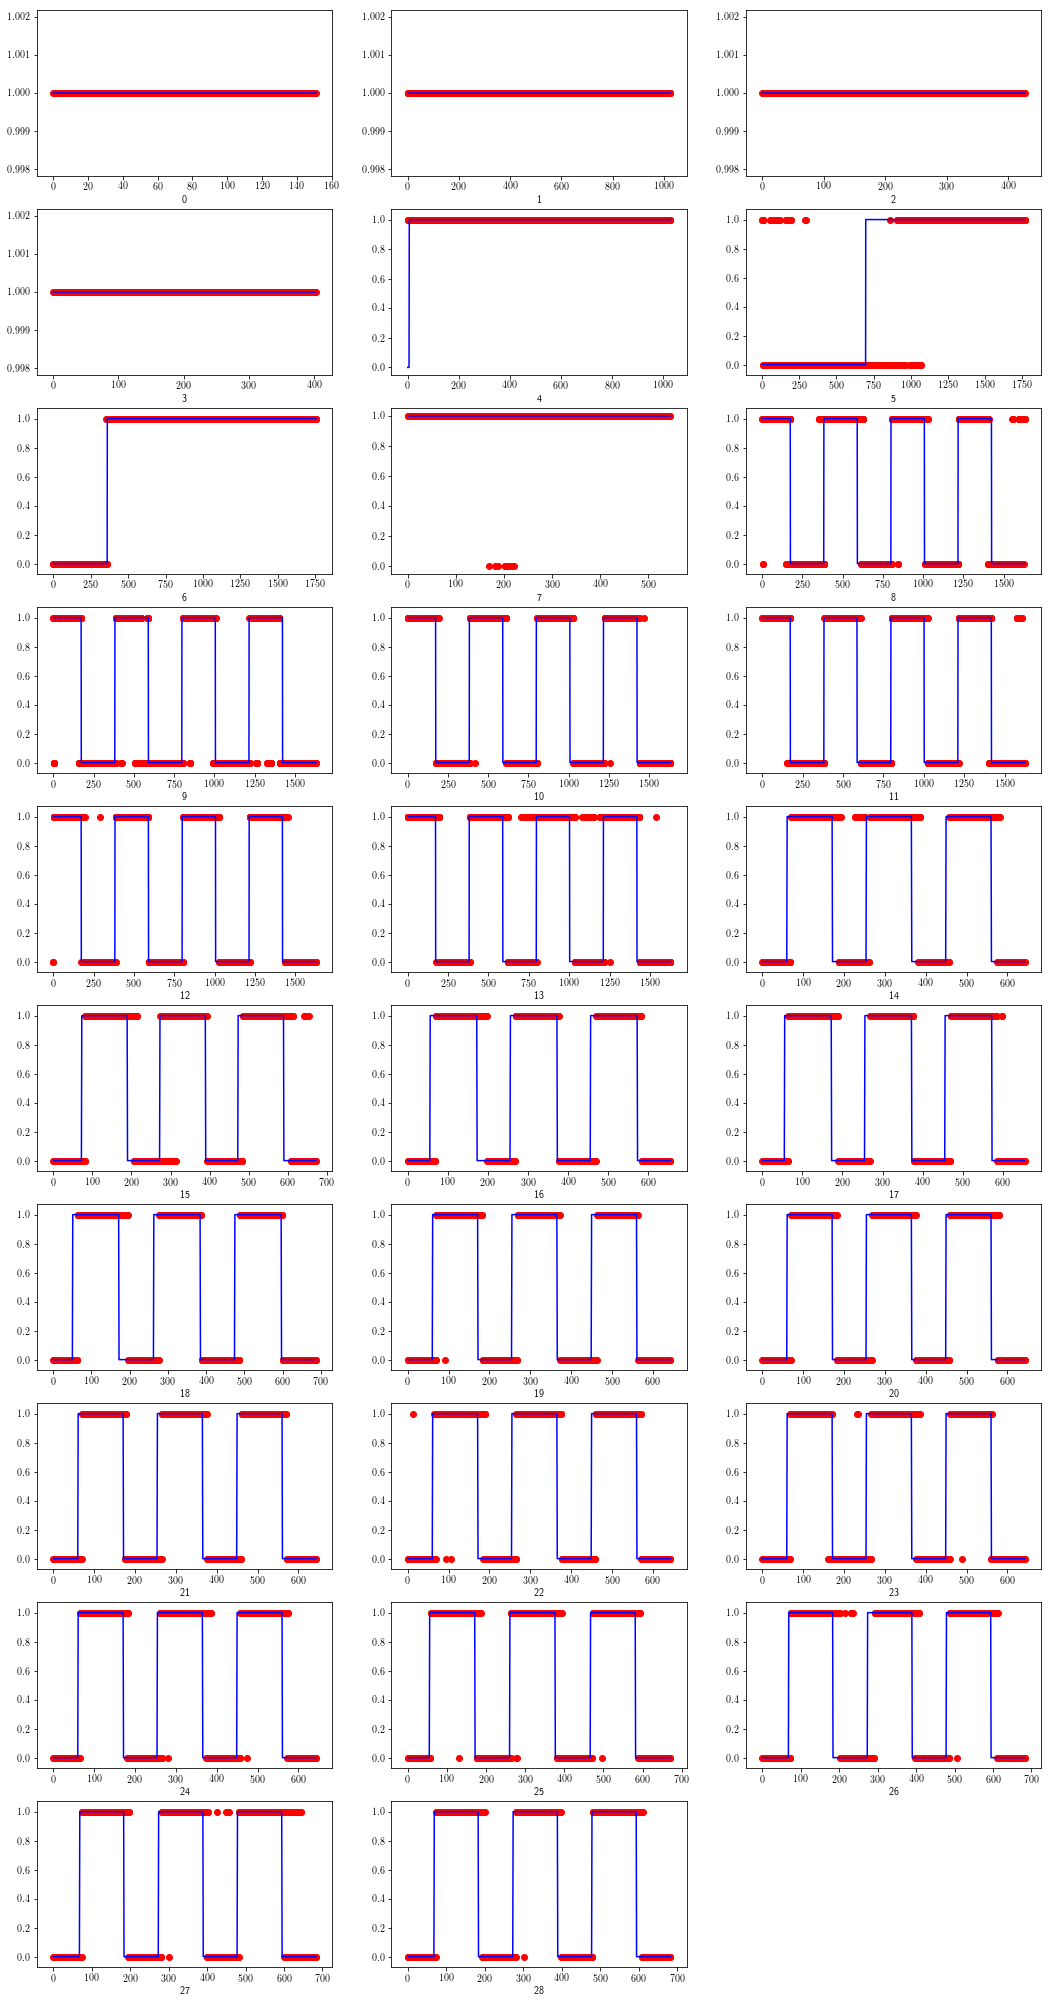

In [87]:
testfeat = np.load(featfile)['features']
testlabs = np.load(featfile)['labels']
print testfeat.shape, testlabs.shape
clfall = np.load(modelfile)['clfall']
bestsel = np.load(modelfile)['bestsel']
stdtran = np.load(modelfile)['stdtran']
pca = np.load(modelfile)['pca']
print np.array(clfall).shape, bestsel.shape, stdtran.shape, pca.shape
k = 8# keep k-th family of clfs, corresponding to clf[k1l(k),k2l(k)]
k1l = [0, 0 ,0, 1, 1, 1, 2, 2, 2]
k2l = [0, 1, 2, 0, 1, 2, 0, 1, 2]
kst1 = [0, 1, 0]
kst2 = [1, 2, 2]
k1, k2 = k1l[k], k2l[k]
# clf2use = [1,1,1,1,1,1,1,1]
# clf2use = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
clf2use = [0,0,1,0,0]
keepkbest = 750 # features to keep for pca
allout = []
fig = plt.figure(figsize=(18,36))
r=10.
for ix in range(testfeat.shape[0]):
    print ix, testlabs[ix].shape, testfeat[ix].shape
    output = []
    for tfix in range(testfeat[ix].shape[0]):
        feats = np.array(testfeat[ix][tfix,:,kst1[k2]:kst2[k2]]).flatten(order='F')[np.newaxis,:]
        rng = np.random.RandomState(2)
        feats += 0.0 * rng.uniform(size=feats.shape)
#         print 'feats: ', feats.shape
        #raw_input()
        stdfeats = stdtran[k1,k2].transform(feats)
        #print 'stdtr: ', stdfeats.shape
        bestfeats = stdfeats[:,bestsel[k1,k2][:keepkbest]]
        #print 'bestf: ', bestfeats.shape
        pcafeats = pca[k1,k2].transform(bestfeats)
        #print 'pcatr: ', pcafeats.shape

        # Use trained classifiers for prediction
        acc = []
        clfout = []
        for i in range(len(names)):
            if clf2use[i] != 1 and clf2use[-1] != 1:
                continue
            clf = clfall[len(names)*k+i]
            if (i+1)%(len(names)) != 0:
                if hasattr(clf, "predict_proba"):
                    acc += [clf.predict_proba(pcafeats)[0,1]]
                else:
                    acc += [clf.predict(pcafeats)[0]]
            else:
                tmpclfin = np.array(clfout)[np.newaxis,:]
                acc += [clf.predict_proba(tmpclfin)[0,1]]
            clfout += [int(acc[-1]>0.5)]

        weights = np.ones(np.array(acc).shape)
        if clf2use[-1] == 0: # majority vote decision
            output.append(int(sum(weights*np.array(acc))>sum(weights)/2))
        else: # ensemble MLP decision
            output.append(acc[-1])
    print np.array(output).shape
    allout.append(output)
    ax = fig.add_subplot(int(r),int(np.ceil(testfeat.shape[0]/r)),ix+1)
    ax.plot(testlabs[ix],'b')
    ax.scatter(range(len(output)),output,color='r')
    ax.set_xlabel(str(ix))
print np.array(allout).shape

In [ ]:
# testfeat = np.load(featfile)['features']
# testlabs = np.load(featfile)['labels']
# print testfeat.shape, testlabs.shape
# clfall = np.load(modelfile)['clfall']
# bestsel = np.load(modelfile)['bestsel']
# stdtran = np.load(modelfile)['stdtran']
# pca = np.load(modelfile)['pca']
# print np.array(clfall).shape, bestsel.shape, stdtran.shape, pca.shape
# k = 8# keep k-th family of clfs, corresponding to clf[k1l(k),k2l(k)]
# k1l = [0, 0 ,0, 1, 1, 1, 2, 2, 2]
# k2l = [0, 1, 2, 0, 1, 2, 0, 1, 2]
# kst1 = [0, 1, 0]
# kst2 = [1, 2, 2]
# k1, k2 = k1l[k], k2l[k]
# # clf2use = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
# clf2use = [0,0,0,0,0,0,1,0,0,0,0,0,0,0]
# keepkbest = 1000 # features to keep for pca
# allout = []
# fig = plt.figure(figsize=(18,36))
# r=10.
# for ix in range(testfeat.shape[0]):
#     print ix, testlabs[ix].shape, testfeat[ix].shape
#     output = []
#     for tfix in range(testfeat[ix].shape[0]):
#         feats = np.array(testfeat[ix][tfix,:,kst1[k2]:kst2[k2]]).flatten(order='F')[np.newaxis,:]
#         rng = np.random.RandomState(2)
#         feats += 0.0 * rng.uniform(size=feats.shape)
# #         print 'feats: ', feats.shape
#         #raw_input()
#         stdfeats = stdtran[k1,k2].transform(feats)
#         #print 'stdtr: ', stdfeats.shape
#         bestfeats = stdfeats[:,bestsel[k1,k2][:keepkbest]]
#         #print 'bestf: ', bestfeats.shape
#         pcafeats = pca[k1,k2].transform(bestfeats)
#         #print 'pcatr: ', pcafeats.shape

#         # Use trained classifiers for prediction
#         acc = []
#         clfout = []
#         for i in range(len(names)):
#             if clf2use[i] != 1 and clf2use[-1] != 1:
#                 continue
#             clf = clfall[len(names)*k+i]
#             if (i+1)%(len(names)) != 0:
#                 if hasattr(clf, "predict_proba"):
#                     acc += [clf.predict_proba(pcafeats)[0,1]]
#                 else:
#                     acc += [clf.predict(pcafeats)[0]]
#             else:
#                 tmpclfin = np.array(clfout)[np.newaxis,:]
#                 acc += [clf.predict_proba(tmpclfin)[0,1]]
#             clfout += [int(acc[-1]>0.5)]

#         weights = np.ones(np.array(acc).shape)
#         if clf2use[-1] == 0: # majority vote decision
#             output.append(int(sum(weights*np.array(acc))>sum(weights)/2))
#         else: # ensemble MLP decision
#             output.append(acc[-1])
#     print np.array(output).shape
#     allout.append(output)
#     ax = fig.add_subplot(int(r),int(np.ceil(testfeat.shape[0]/r)),ix+1)
#     ax.plot(testlabs[ix],'b')
#     ax.scatter(range(len(output)),output,color='r')
#     ax.set_xlabel(str(ix))
# print np.array(allout).shape

In [88]:
# from sklearn.metrics import classification_report, confusion_matrix

for ix in range(testfeat.shape[0]):
    print classification_report(testlabs[ix],map(int,allout[ix]))
    cm = confusion_matrix(testlabs[ix],map(int,allout[ix]))
    cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+np.finfo(float).eps)
    print cm

             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00       152

avg / total       1.00      1.00      1.00       152

[[ 1.]]
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00      1027

avg / total       1.00      1.00      1.00      1027

[[ 1.]]
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00       428

avg / total       1.00      1.00      1.00       428

[[ 1.]]
             precision    recall  f1-score   support

        1.0       1.00      1.00      1.00       404

avg / total       1.00      1.00      1.00       404

[[ 1.]]
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         6
        1.0       0.99      1.00      1.00      1024

avg / total       0.99      0.99      0.99      1030

[[ 0.  1.]
 [ 0.  1.]]
             precision    recall  f1-score   support

        0.0       0.70      

/home/jagrio/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jagrio/.local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
